# Cellular Deconvolution Notebook

author: Simon Lee (slee@celsiustx.com)

You will need to install the following methods to properly use this notebook 

- [cellanneal](https://github.com/LiBuchauer/cellanneal)
- [Kassandra](https://github.com/BostonGene/Kassandra)

These repos can be cloned inside the "source" folder for usability. The structure below demonstrates what I mean:

src</br>
|_ cellanneal </br>
|_ Kassandra </br>
|_ master_deconvolution.ipynb</br>



# Table of Contents
* [Motivation](#0)
* [Imports & Loading functions](#1)
* [cellanneal](#2)
    * [GSE107572](#2_1)
    * [GSE1479433](#2_2)
* [Kassandra](#3)
    * [GSE107572](#3_1)
    * [GSE1479433](#3_2)
* [SVR](#4)
    * [GSE107572](#4_1)
    * [GSE1479433](#4_2)



# Motivation <a class="anchor" id="0"></a>

Cellular deconvolution (also referred to as cell type composition or cell proportion estimation) refers to computational techniques aiming at estimating the proportions of different cell types in samples collected from a tissue. Over the past few years many methods have been implemented using a wide spread of machine learning methods which have been considered the "State of the Art". However based on the paper, [Clustering-independent estimation of cell abundances in bulk tissues using single-cell RNA-seq data](https://www.biorxiv.org/content/10.1101/2023.02.06.527318v1.full.pdf), we were able to learn that a lot of deconvolutions methods accuracy is highly driven on the gene expression signature which are typically required as input to estimate the cell proportions. Since then there have been more methods developed that don't require a gene signature set but require some form of single cell reference to infer the cellular proportions. Therefore this notebook takes a look at widely different methods found across the literature and provides an easy to use interface for the user. Part of the challenge when working with open source codebases is that reproducability becomes a lot of work because there may be missing files, classified datasets involving real patients, etc. Therefore this notebook's emphasis is really just to provide the user with everything they will need to be able to perform a proper benchmark of different deconvolution methods for themselves. In this repository you will find two datasets in the `\data` folder, with the required paired bulk samples along with an othogonal flow cytometry matrix ("ground truth) to benchmark on PBMC related datasets (`GSE107572, GSE1479433`). If you wou;d like to retrain these models from scratch, you will need to provide a training set with a gene signature set coming from the same tissue. For validation purposes some form of orthogonal qunaitifcation is required. If you are interested in including your own models, you are also free to do so by following the pipeline demonstarted of the three different methods seen in this notebook: **cellanneal (annealing/rank coefficients minimization function), Kassandra (Ligh Gradient Boosting Decision Tree Model), & SVR (support vector regression)**. 

## Imports & Loading Functions <a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# import deconvolution methods
import cellanneal
from Kassandra.core.mix import Mixers
from Kassandra.core.cell_types import CellTypes
from Kassandra.core.model import DeconvolutionModel
from Kassandra.core.plotting import print_cell_matras, cells_p, print_all_cells_in_one
from Kassandra.core.utils import *
from scipy.optimize import nnls
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler

# statistical tests
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# stats & plot specific from .py files
from plot import Plot
from stats import statsTest
from helper import flatten, gene_intersection
import project_configs as project_configs

from tqdm import tqdm

In [2]:
# plot parameters all coming from project.configurations
plt.style.use(project_configs.style)
plt.rcParams['font.family'] = project_configs.font_family
plt.rcParams['font.serif'] = project_configs.font_serif
plt.rcParams['font.monospace'] = project_configs.font_monospace
plt.rcParams['font.size'] = project_configs.font_size
plt.rcParams['axes.labelsize'] = project_configs.axes_label_size
plt.rcParams['axes.labelweight'] = project_configs.axes_label_weight
plt.rcParams['axes.titlesize'] = project_configs.axes_title_size
plt.rcParams['xtick.labelsize'] = project_configs.xtick_label_size
plt.rcParams['ytick.labelsize'] = project_configs.ytick_label_size
plt.rcParams['legend.fontsize'] = project_configs.legend_font_size 
plt.rcParams['figure.titlesize'] = project_configs.figure_title_size
plt.rcParams['image.cmap'] = project_configs.image_cmap 
plt.rcParams['image.interpolation'] = project_configs.image_interpolation 
plt.rcParams['figure.figsize'] = project_configs.figure_size
plt.rcParams['axes.grid']=project_configs.axes_grid
plt.rcParams['lines.linewidth'] = project_configs.lines_line_width
plt.rcParams['lines.markersize'] = project_configs.lines_marker_size
cells_p = project_configs.cells_p

### other helpful methods

In [ ]:
def gene_sig_builder(df, ref):
    '''
    Gene Signature constructor
    '''
    

### Models Fitting

In [3]:
signature = pd.read_csv('./cellanneal/example_data/sc_PBMC_gene_mean_signature.csv',index_col=0)
bulk = pd.read_csv('../data/GSE107572_expr.tsv.tar.gz',sep='\t',index_col=0)

In [4]:
signature_match, bulk_match = gene_intersection(signature, bulk)
print(signature_match.shape[0],"==", bulk_match.shape[0])

12998 == 12998


### Cellanneal <a class="anchor" id="2"></a>

In [5]:
gene_dict = cellanneal.make_gene_dictionary(
                    signature,
                    bulk,
                    disp_min=0.5,
                    bulk_min=1e-5,
                    bulk_max=0.01)

3862 highly variable genes identified in cell type
        reference.
	1951 of these are within thresholds for sample SRR6337113
	1723 of these are within thresholds for sample SRR6337114
	2159 of these are within thresholds for sample SRR6337115
	2199 of these are within thresholds for sample SRR6337116
	1912 of these are within thresholds for sample SRR6337117
	1876 of these are within thresholds for sample SRR6337118
	1835 of these are within thresholds for sample SRR6337119
	1856 of these are within thresholds for sample SRR6337120
	1926 of these are within thresholds for sample SRR6337121


In [6]:
ca_preds = cellanneal.deconvolve(
                signature,
                bulk,
                maxiter=1000,
                gene_dict=gene_dict)

Deconvolving sample 1 of 9 (SRR6337113) ...
Deconvolving sample 2 of 9 (SRR6337114) ...
Deconvolving sample 3 of 9 (SRR6337115) ...
Deconvolving sample 4 of 9 (SRR6337116) ...
Deconvolving sample 5 of 9 (SRR6337117) ...
Deconvolving sample 6 of 9 (SRR6337118) ...
Deconvolving sample 7 of 9 (SRR6337119) ...
Deconvolving sample 8 of 9 (SRR6337120) ...
Deconvolving sample 9 of 9 (SRR6337121) ...


## GSE107572 <a class="anchor" id="2_1"></a>

Multiply by 100 to get cell percentages not just units that add up to 1

In [7]:
ca_preds_100 = ca_preds * 100

In [8]:
# plotting object
plotter = Plot()

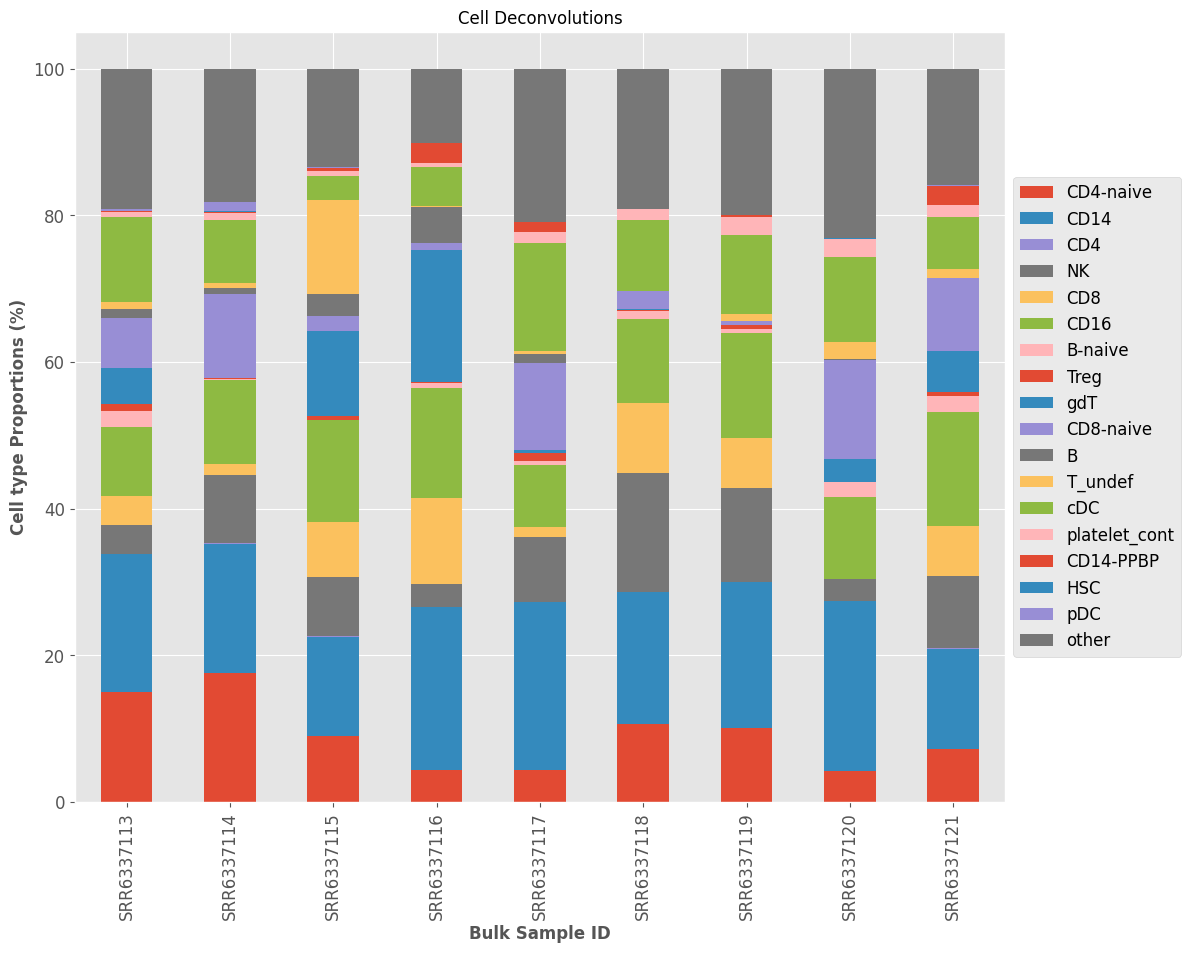

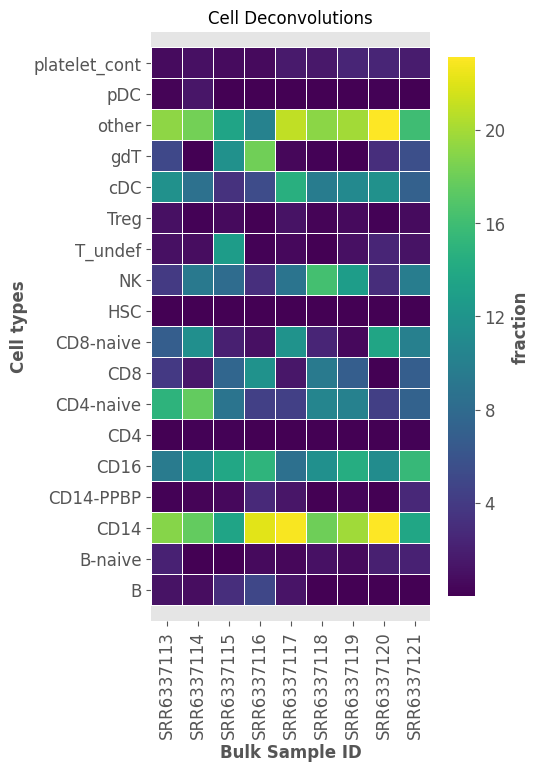

In [9]:
plotter.stack_plot(ca_preds_100)
plotter.heat_map(ca_preds_100)

need the columns to match names to get the correlation plots

In [10]:
# renaming columns to match cytof "ground truth" data
ca_preds_copy = ca_preds_100.T.copy()
ca_preds_copy.loc['B_cells'] = ca_preds_copy.loc[['B', 'B-naive']].sum()
ca_preds_copy.loc['CD4_T_cells'] = ca_preds_copy.loc[['CD4', 'CD4-naive']].sum()
ca_preds_copy.loc['CD8_T_cells'] = ca_preds_copy.loc[['CD8']].sum()
ca_preds_copy.loc['NK_cells'] = ca_preds_copy.loc[['NK']].sum()
ca_preds_copy.loc['Tregs'] = ca_preds_copy.loc[['Treg']].sum()
ca_preds_copy.loc['T_cells'] = ca_preds_copy.loc[['CD8_T_cells', 'CD4_T_cells', 'Tregs', 'T_undef']].sum()
ca_preds_copy.loc['Lymphocytes'] = ca_preds_copy.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [12]:
cytof1 = pd.read_csv('../data/GSE107572_cytof.tsv.tar.gz', sep='\t', index_col=0)

array([[<AxesSubplot: title={'center': 'B_cells, corr = 0.428\np = 0.251'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.722\np = 0.028'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = 0.746\np = 0.021'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Lymphocytes, corr = 0.588\np = 0.096'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'NK_cells, corr = 0.894\np = 0.001'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'T_cells, corr = 0.595\np = 0.091'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center':

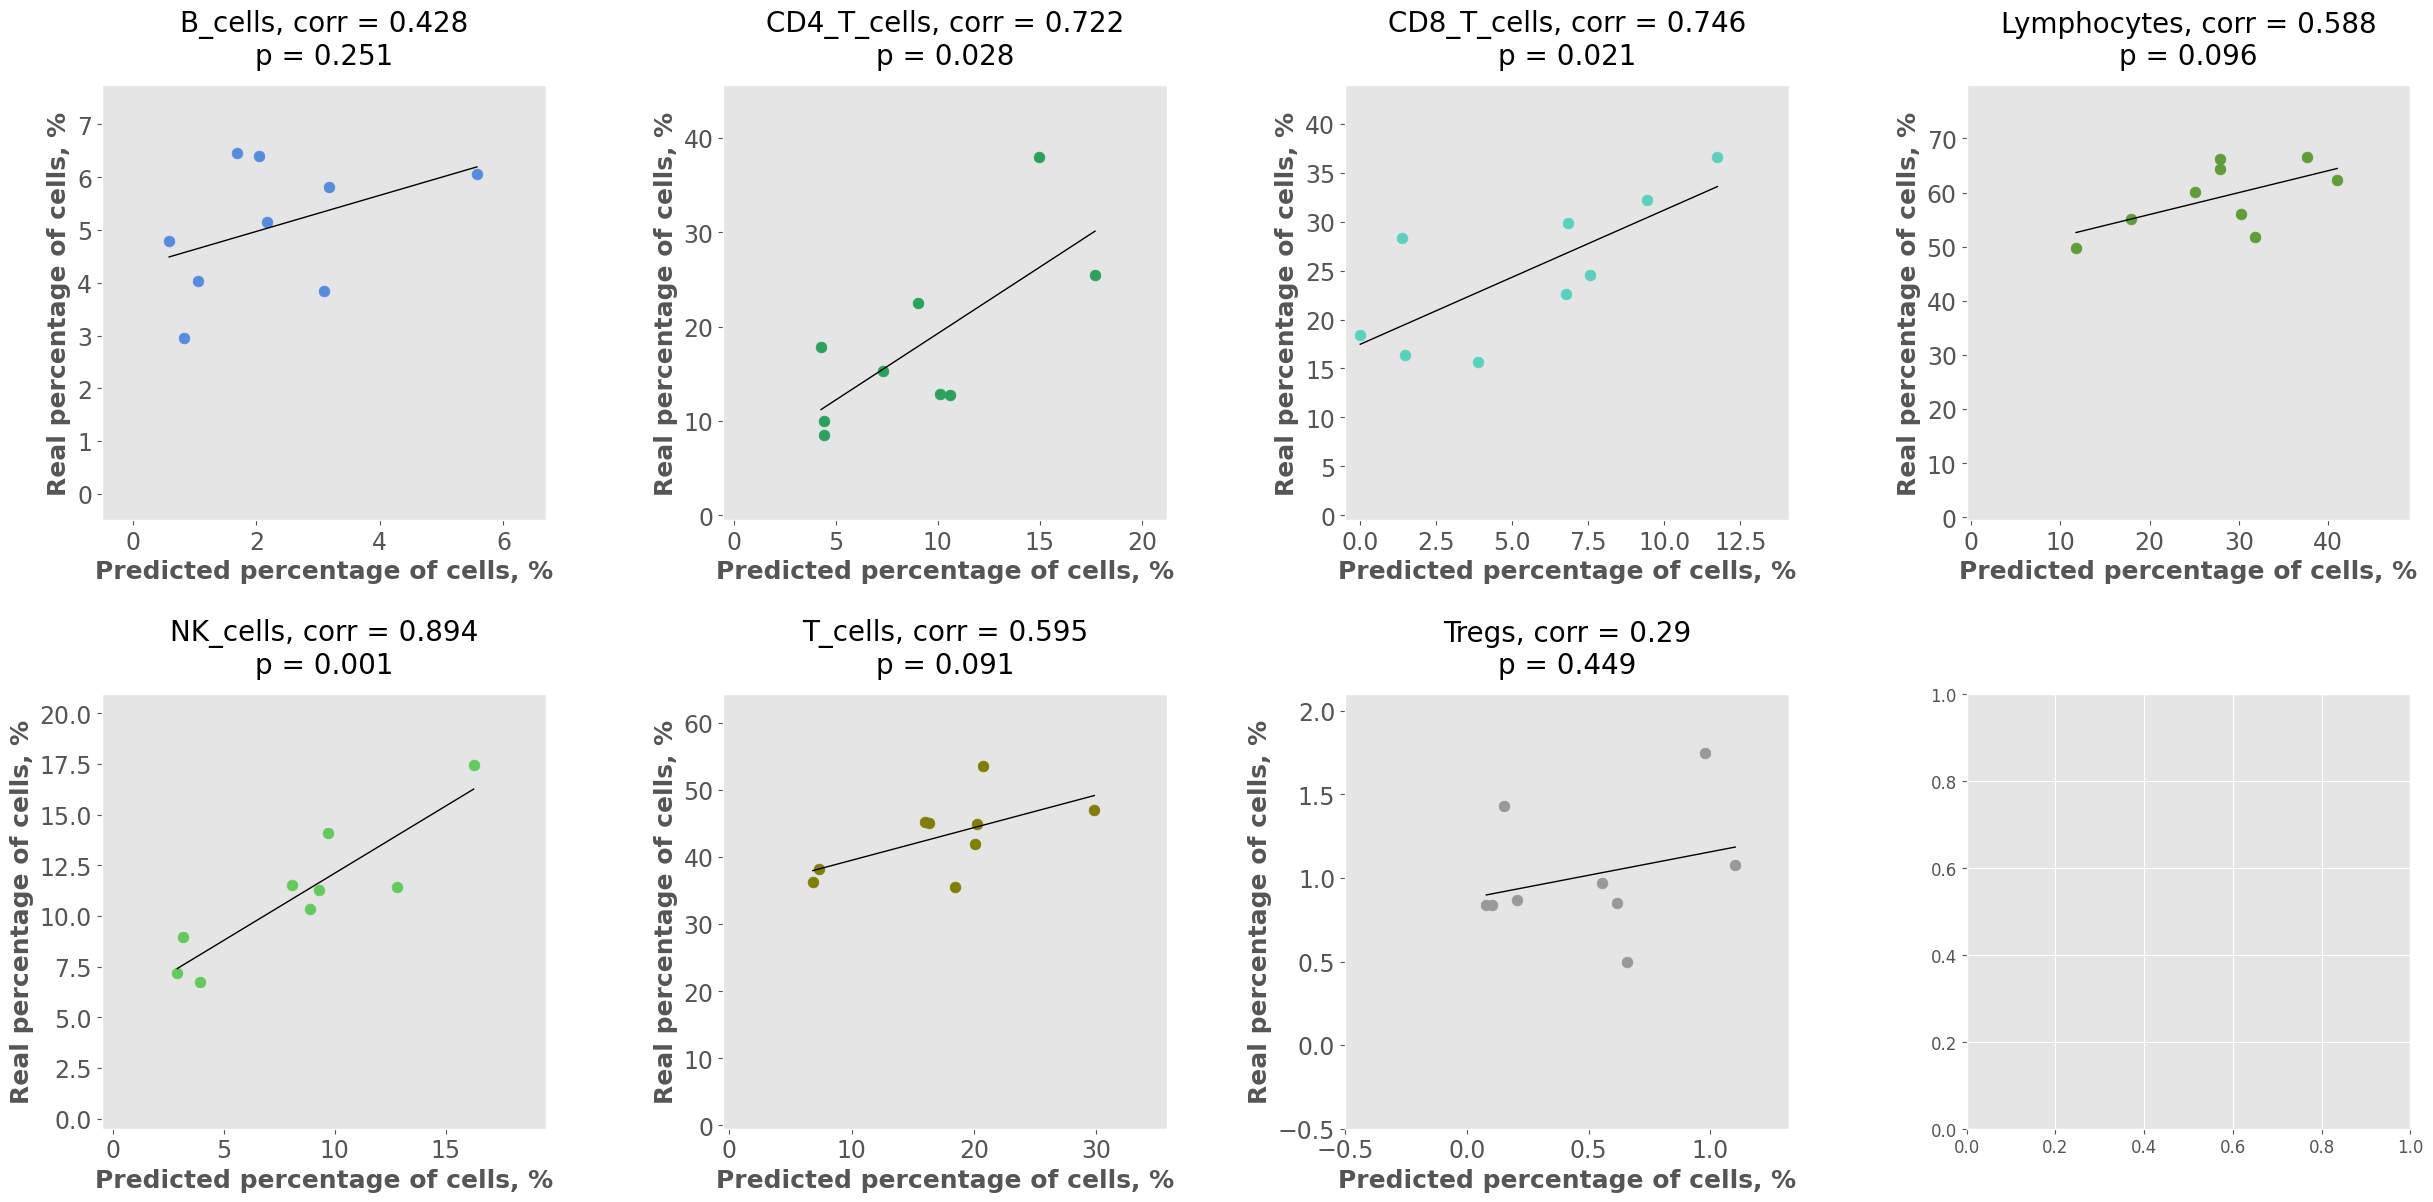

In [13]:
plotter.corr_plot(ca_preds_copy, cytof1, pallete=cells_p)

#### The statsTest class takes the statistics of the whole mixture

Statistical Tests
------------------------
RMSE: 17.988 
Pearson Correlation Coefficient: 0.88 
P value: 0.0 
R^2: 0.216


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

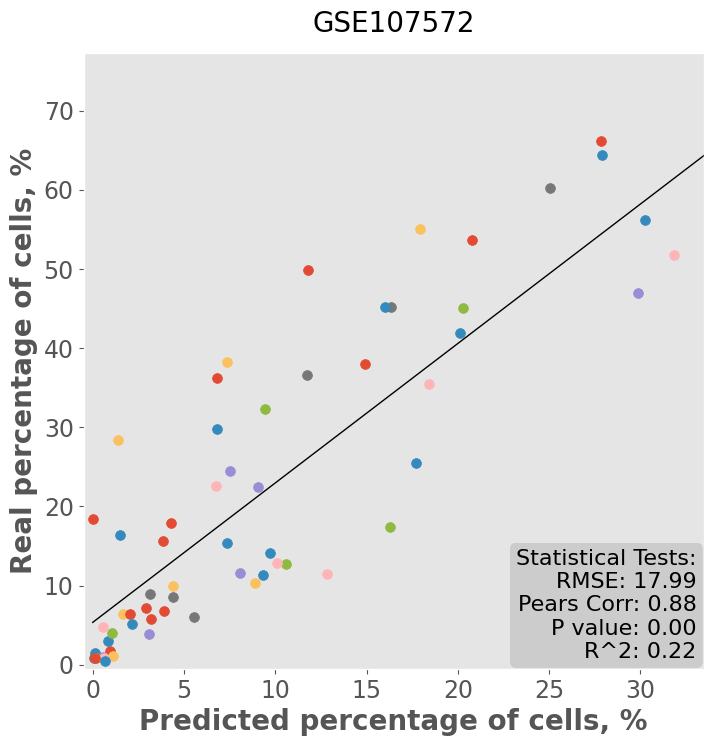

In [15]:
title = 'GSE107572'
plotter.print_cell_whole(ca_preds_copy, cytof1, pallete = cells_p, title=title, stat=True)

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {-2.811 +/- 1.515}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {-8.941 +/- 6.712}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-19.502 +/- 5.124}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of Lymphocytes: {-31.249 +/- 7.372}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of NK_cells: {-2.67 +/- 2.133}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of T_cells: {-25.769 +/- 5.893}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <Axe

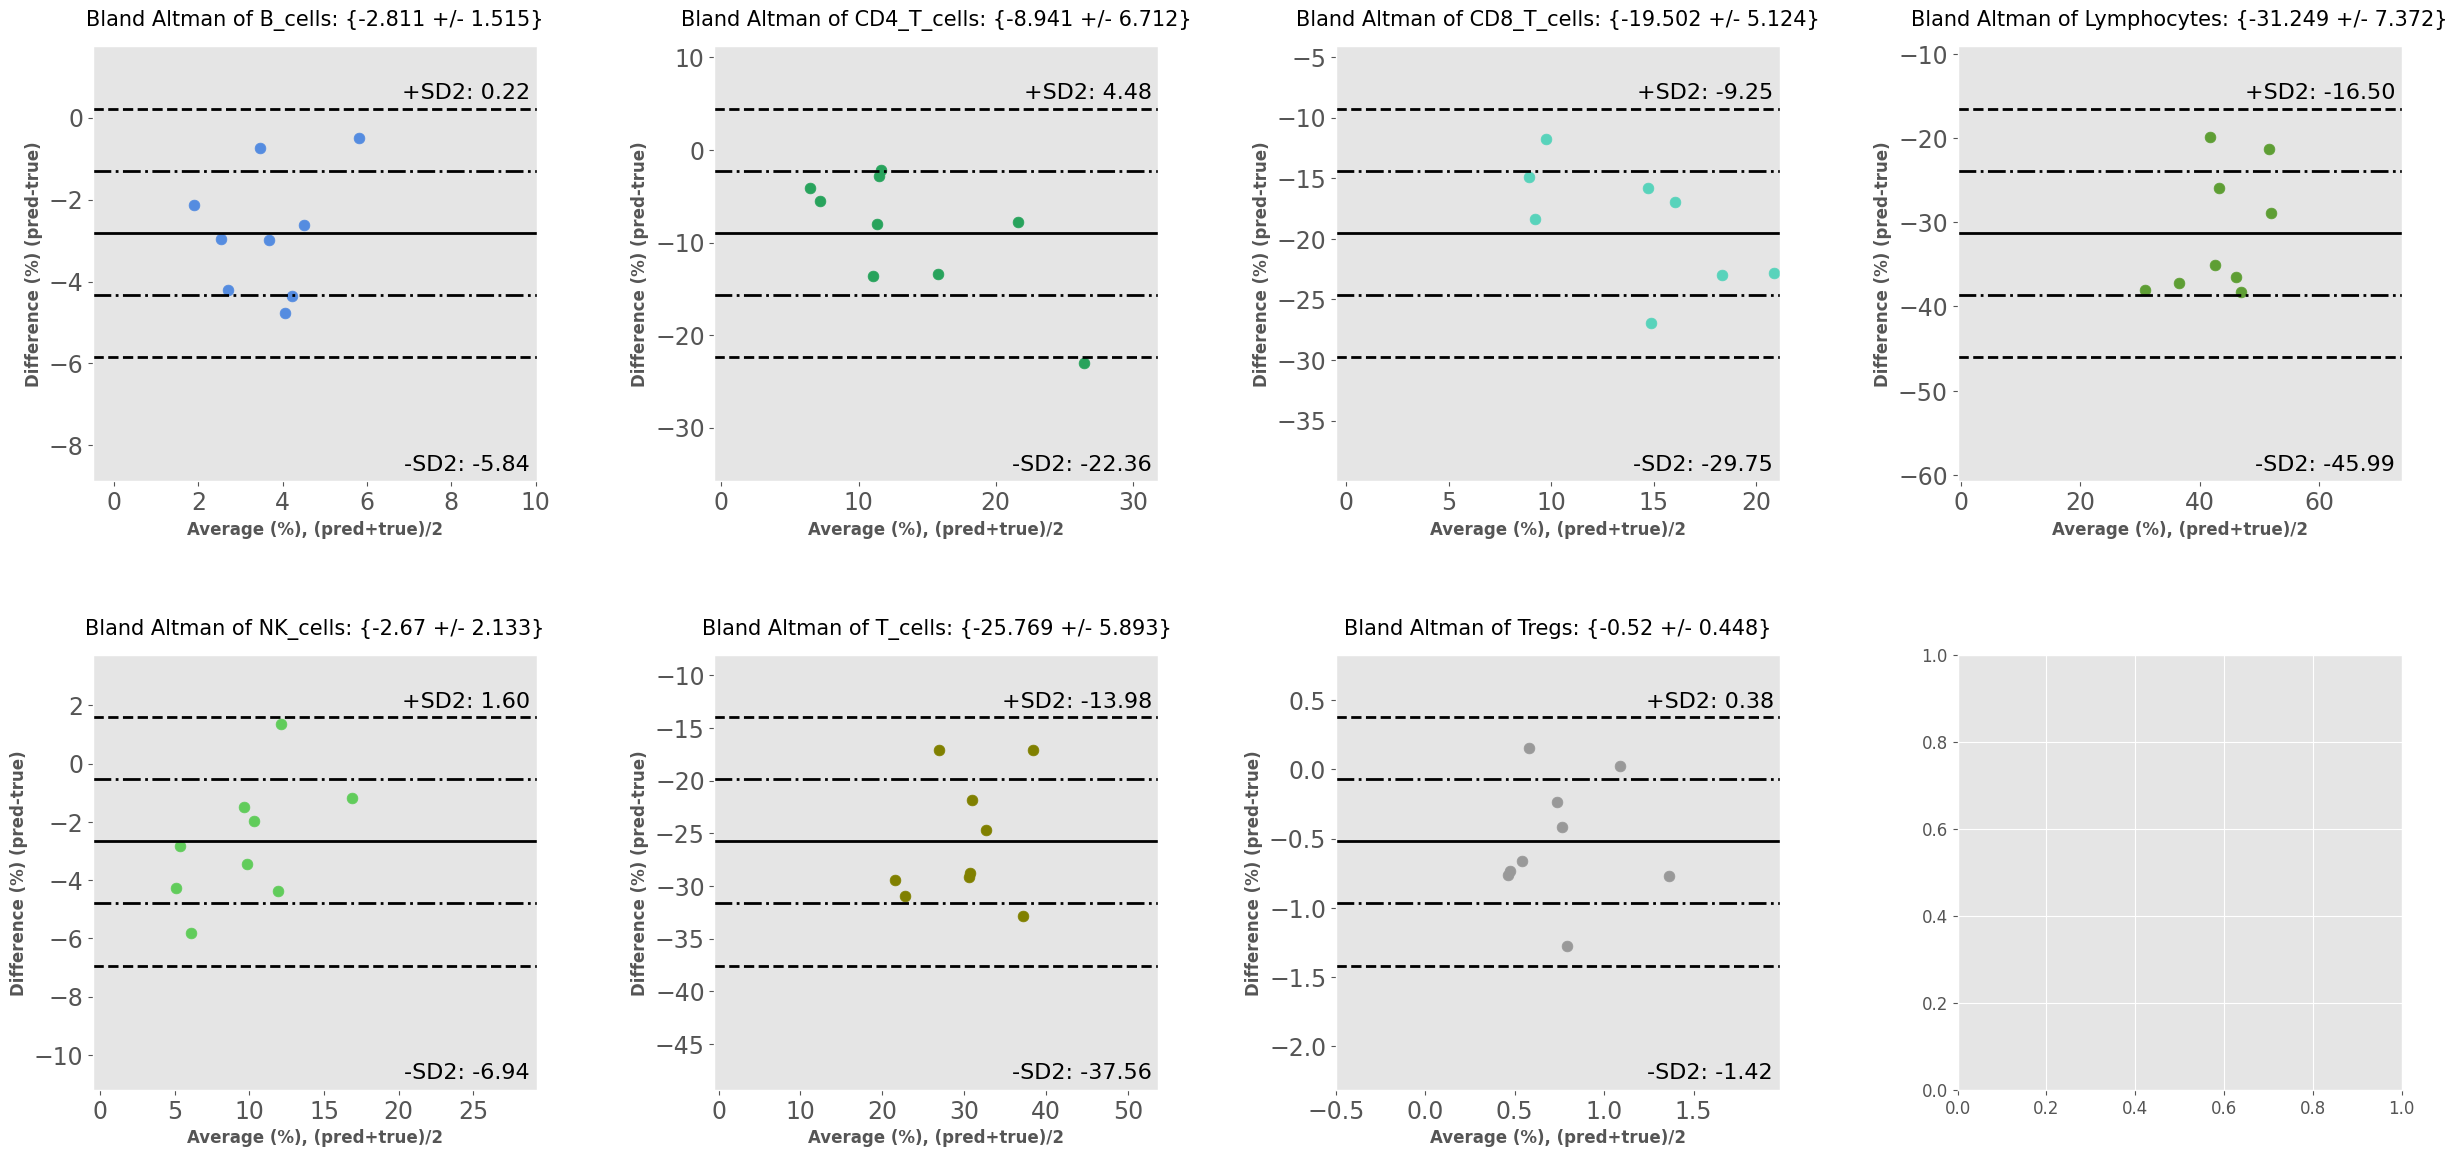

In [16]:
plotter.bland_altman(ca_preds_copy, cytof1, pallete = cells_p)

In [20]:
# get a color pallete for color samples
ind_names = ca_preds_100.index.intersection(cytof1.index)
sample_color = plotter.get_cmap(len(ind_names))


In [23]:
cytof1

,SRR6337113,SRR6337114,SRR6337115,SRR6337116,SRR6337117,SRR6337118,SRR6337119,SRR6337120,SRR6337121
GSM,GSM2871599,GSM2871600,GSM2871601,GSM2871602,GSM2871603,GSM2871604,GSM2871605,GSM2871606,GSM2871607
B_cells,5.81,2.96,3.84,6.0600000000000005,6.45,4.03,4.8,6.4,5.16
CD4_T_cells,37.96,25.52,22.47,8.53,9.96,12.740000000000002,12.89,17.86,15.329999999999998
CD8_T_cells,15.64,16.38,24.52,36.61,28.34,32.27,22.6,18.39,29.84
Monocytes,20.01,24.81,19.43,26.36,32.379999999999995,23.87,28.15,35.86,20.03
Dendritic_cells,1.6,2.34,3.5700000000000003,4.24,2.42,3.29,4.760000000000002,2.27,4.26
NK_cells,6.75,11.28,11.54,8.959999999999997,10.35,17.46,11.44,7.1800000000000015,14.09
Neutrophils,2.45,4.84,3.67,3.32,4.43,5.050000000000002,2.5700000000000003,3.97,2.68
Tregs,1.7500000000000002,1.43,0.97,0.84,1.08,0.8699999999999999,0.8500000000000001,0.84,0.5
Lymphocytes,66.16,56.14,62.37000000000001,60.16,55.1,66.5,51.73,49.83000000000001,64.42


In [22]:
ca_preds_copy

,SRR6337113,SRR6337114,SRR6337115,SRR6337116,SRR6337117,SRR6337118,SRR6337119,SRR6337120,SRR6337121
CD4-naive,14.924457,17.568928,8.921512,4.386428,4.386077,10.554480,10.070109,4.250614,7.181304
CD14,18.926833,17.610480,13.511339,22.143525,22.891129,18.050149,19.884964,23.140144,13.702889
CD4,0.010451,0.134444,0.129375,0.020701,0.020676,0.021138,0.018354,0.034159,0.155231
NK,3.913113,9.313474,8.076680,3.156352,8.873494,16.263980,12.811671,2.902947,9.712200
CD8,3.875029,1.478519,7.542146,11.749371,1.369590,9.443008,6.781487,0.004001,6.830283
CD16,9.503792,11.462072,13.821335,15.030014,8.443791,11.517171,14.300119,11.204617,15.542434
B-naive,2.082805,0.039388,0.023010,0.631454,0.444330,1.039922,0.585976,2.014488,2.156182
Treg,0.977223,0.151956,0.555045,0.080388,1.102120,0.207415,0.616850,0.105610,0.656768
gdT,4.999626,0.015313,11.575808,18.106715,0.408935,0.115897,0.018316,3.048868,5.553986
CD8-naive,6.833272,11.476649,2.070248,0.928278,11.877856,2.401487,0.465709,13.596909,9.945438


ValueError: could not broadcast input array from shape (2,) into shape (0,)

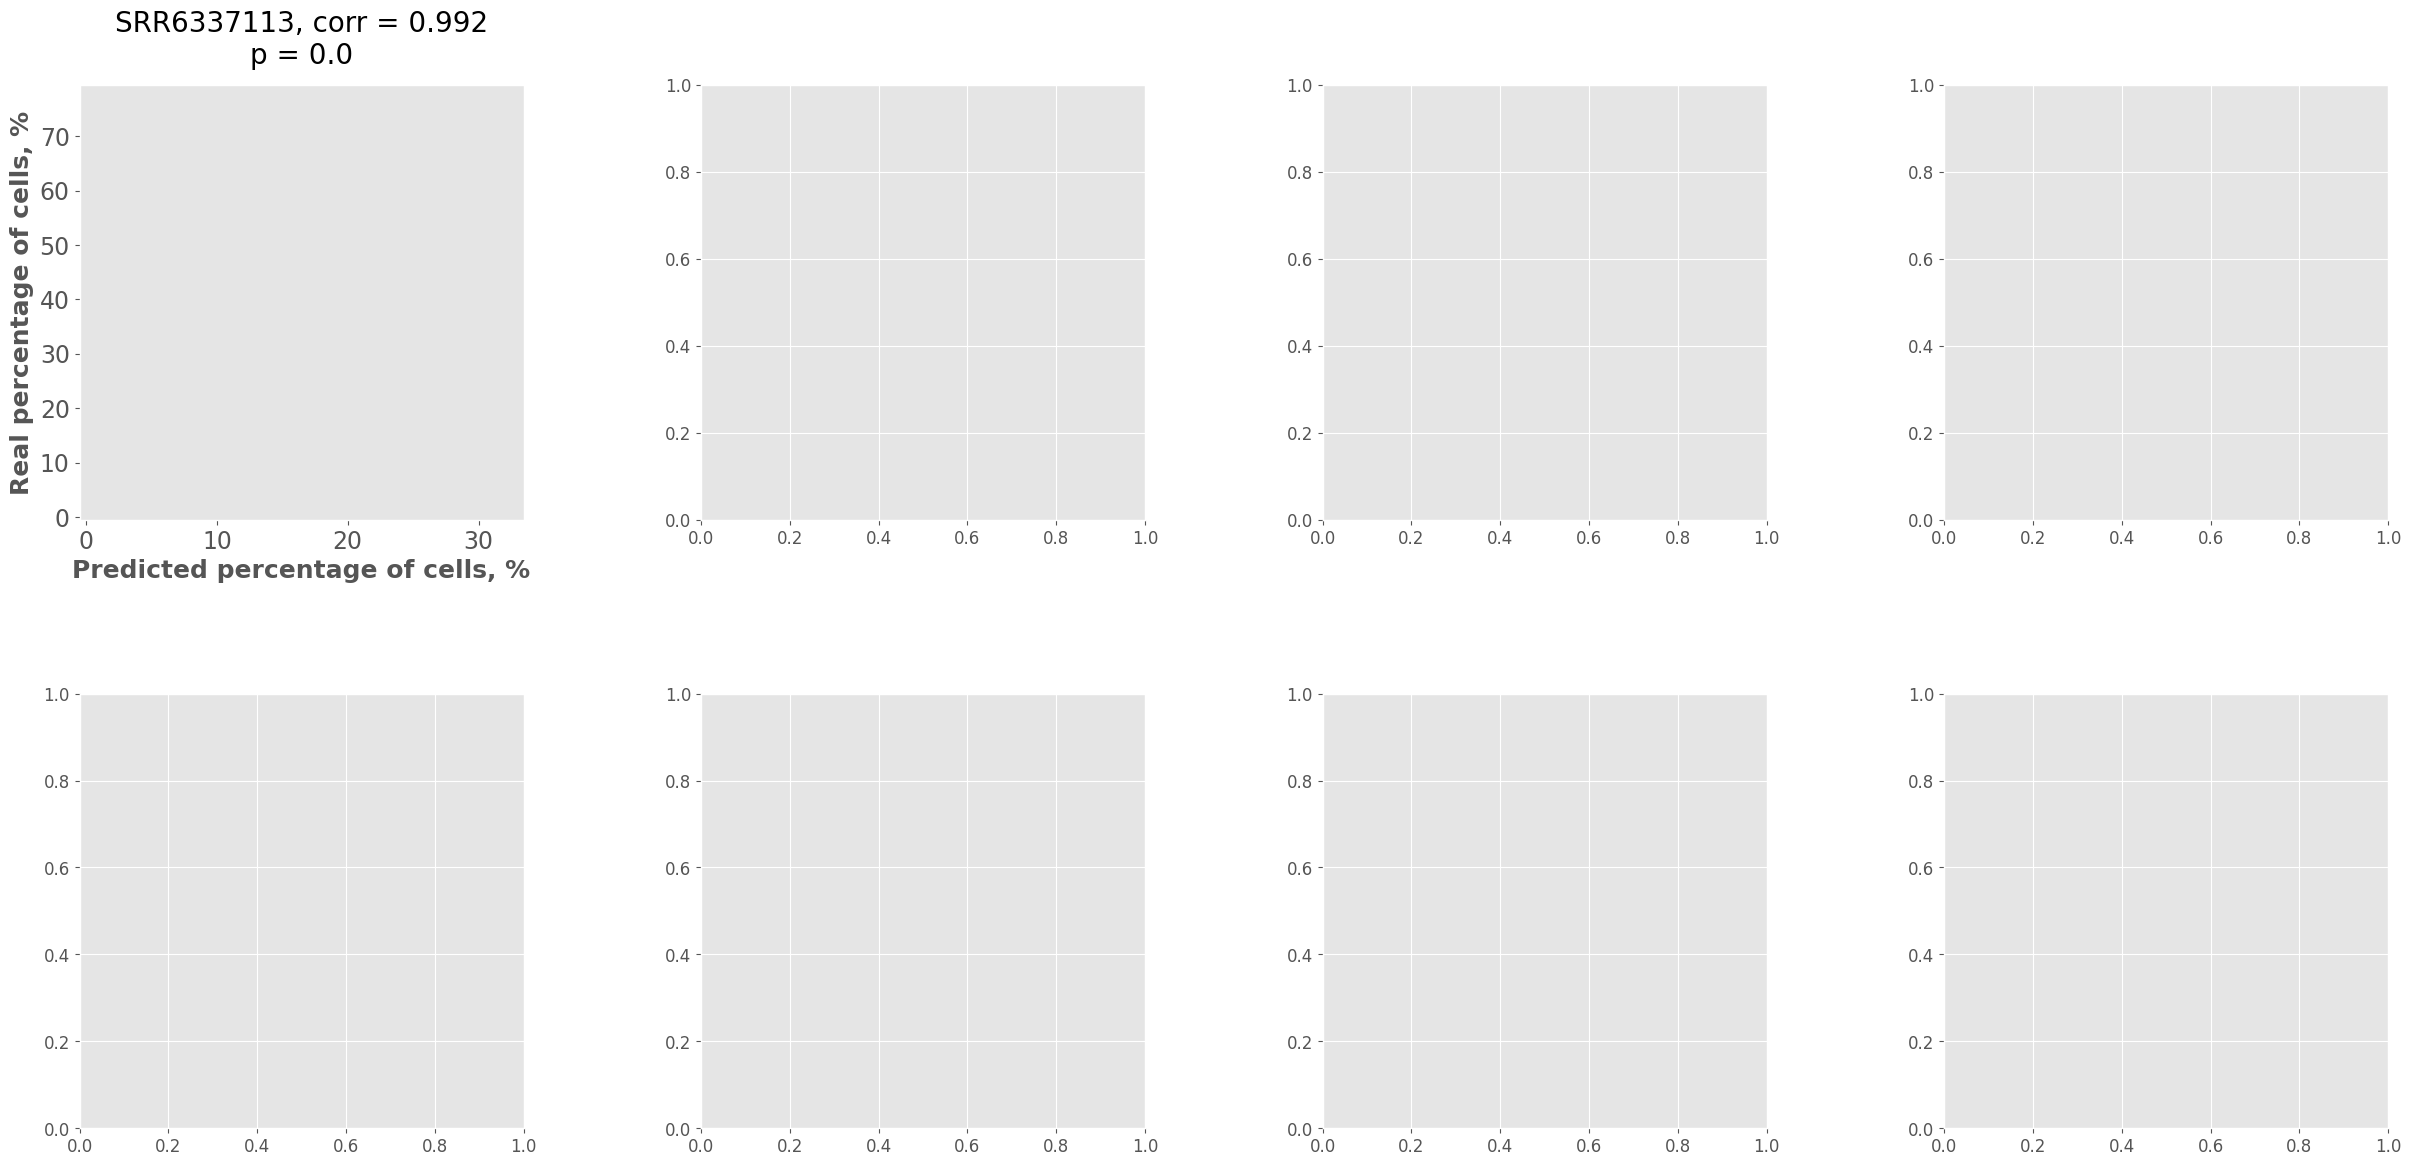

In [24]:
plotter.plot_sample(ca_preds_copy, cytof1, pallete = sample_color)

ValueError: could not broadcast input array from shape (2,) into shape (0,)

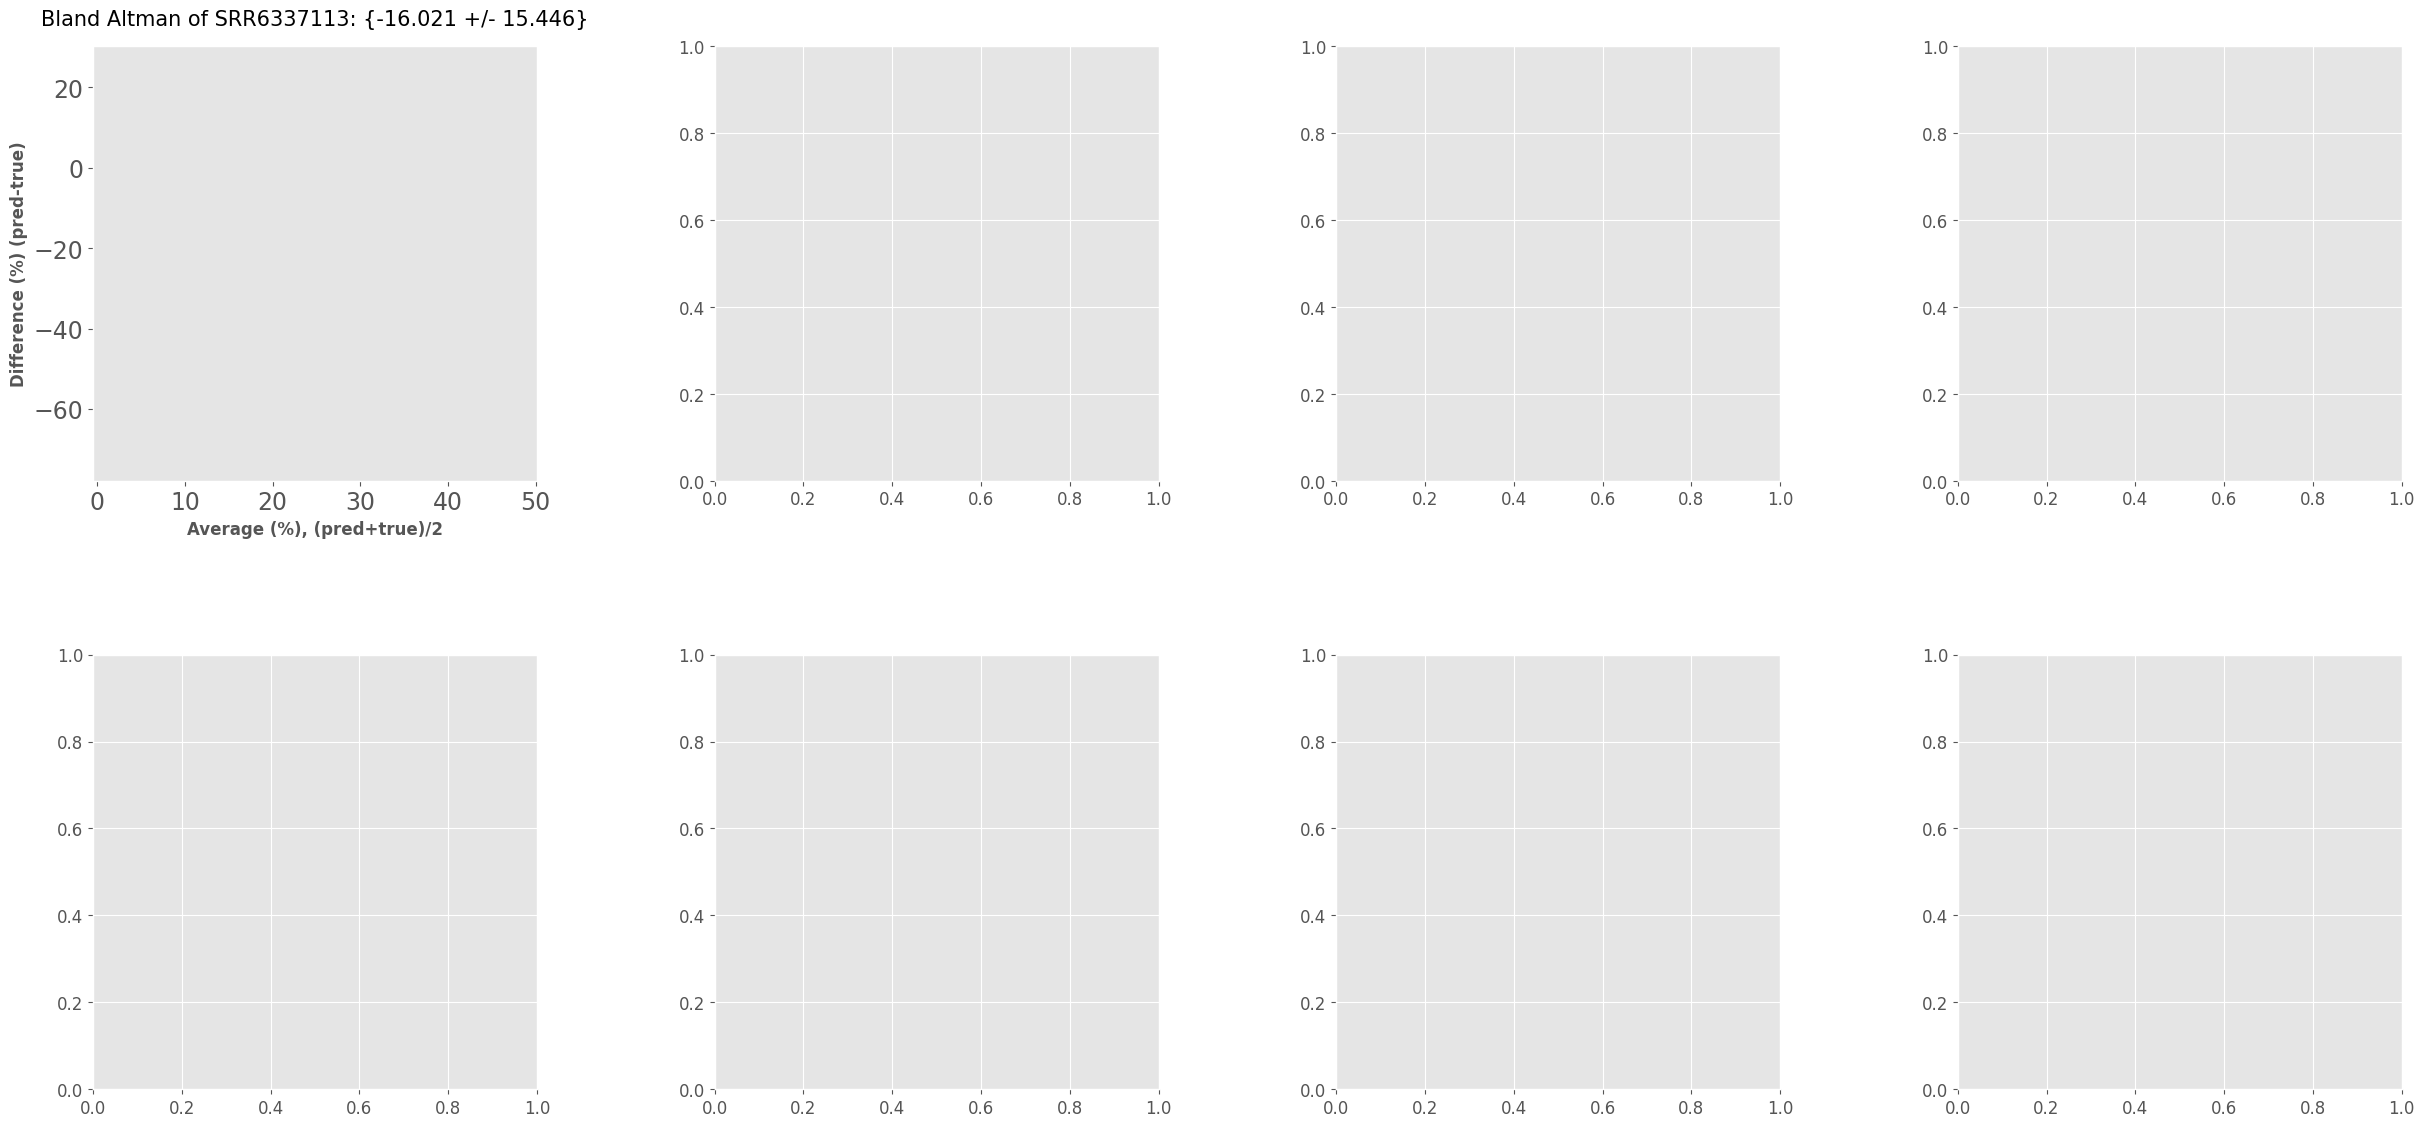

In [19]:
plotter.bland_altman_v2(ca_preds_copy, cytof1, pallete = sample_color)

## GSE1479433 <a class="anchor" id="2_2"></a>

In [218]:
title = 'GSE1479433'
bulk2 = pd.read_csv('../data/GSE1479433.tsv', sep='\t', index_col=0)
cytof2 = pd.read_csv('../data/GSE1479433_cytometry_df.tsv', sep='\t', index_col=0)

In [219]:
gene_dict = cellanneal.make_gene_dictionary(
                    signature,
                    bulk2,
                    disp_min=0.5,
                    bulk_min=1e-5,
                    bulk_max=0.01)

3502 highly variable genes identified in cell type
        reference.
	2399 of these are within thresholds for sample F0222
	2390 of these are within thresholds for sample F0223
	2425 of these are within thresholds for sample F0224
	2269 of these are within thresholds for sample F0229
	2398 of these are within thresholds for sample F0230
	2338 of these are within thresholds for sample F0231
	2066 of these are within thresholds for sample F0232
	2168 of these are within thresholds for sample F0274
	2223 of these are within thresholds for sample F0303
	2309 of these are within thresholds for sample F0304
	2203 of these are within thresholds for sample F0305
	2367 of these are within thresholds for sample F0306
	2237 of these are within thresholds for sample F0307
	2380 of these are within thresholds for sample F0308
	1751 of these are within thresholds for sample F0460
	2219 of these are within thresholds for sample F0462
	2212 of these are within thresholds for sample F0590
	2012 of the

In [220]:
ca_preds2 = cellanneal.deconvolve(
                signature,
                bulk2,
                maxiter=1000,
                gene_dict=gene_dict)

Deconvolving sample 1 of 45 (F0222) ...
Deconvolving sample 2 of 45 (F0223) ...
Deconvolving sample 3 of 45 (F0224) ...
Deconvolving sample 4 of 45 (F0229) ...
Deconvolving sample 5 of 45 (F0230) ...
Deconvolving sample 6 of 45 (F0231) ...
Deconvolving sample 7 of 45 (F0232) ...
Deconvolving sample 8 of 45 (F0274) ...
Deconvolving sample 9 of 45 (F0303) ...
Deconvolving sample 10 of 45 (F0304) ...
Deconvolving sample 11 of 45 (F0305) ...
Deconvolving sample 12 of 45 (F0306) ...
Deconvolving sample 13 of 45 (F0307) ...
Deconvolving sample 14 of 45 (F0308) ...
Deconvolving sample 15 of 45 (F0460) ...
Deconvolving sample 16 of 45 (F0462) ...
Deconvolving sample 17 of 45 (F0590) ...
Deconvolving sample 18 of 45 (F0591) ...
Deconvolving sample 19 of 45 (F0592) ...
Deconvolving sample 20 of 45 (F0594) ...
Deconvolving sample 21 of 45 (F0595) ...
Deconvolving sample 22 of 45 (F0596) ...
Deconvolving sample 23 of 45 (F0597) ...
Deconvolving sample 24 of 45 (F0598) ...
Deconvolving sample 25 of

In [221]:
ca_preds2_100 = ca_preds2*100

In [ ]:
plotter.stack_plot(ca_preds2_100)
plotter.heat_map(ca_preds2_100)

In [222]:
# renaming columns to match cytof "ground truth" data
ca_preds_copy2 = ca_preds2_100.T.copy()
ca_preds_copy2.loc['B_cells'] = ca_preds_copy2.loc[['B', 'B-naive']].sum()
ca_preds_copy2.loc['CD4_T_cells'] = ca_preds_copy2.loc[['CD4', 'CD4-naive']].sum()
ca_preds_copy2.loc['CD8_T_cells'] = ca_preds_copy2.loc[['CD8']].sum()
ca_preds_copy2.loc['NK_cells'] = ca_preds_copy2.loc[['NK']].sum()
ca_preds_copy2.loc['Tregs'] = ca_preds_copy2.loc[['Treg']].sum()
ca_preds_copy2.loc['T_cells'] = ca_preds_copy2.loc[['CD8_T_cells', 'CD4_T_cells', 'Tregs', 'T_undef']].sum()
ca_preds_copy2.loc['Lymphocytes'] = ca_preds_copy2.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [ ]:
flatten(ca_preds_copy2, cytof2)

In [ ]:
plotter.corr_plot(ca_preds_copy2, cytof2, pallete=cells_p)

In [ ]:
plotter.print_cell_whole(ca_preds_copy2, cytof2, pallete = cells_p, title=title, stat=True)

these results make sense as alot of cell subtypes are being incorrectly identified compared to the CyTOF data

In [ ]:
plotter.bland_altman(ca_preds_copy2, cytof2, pallete = cells_p)

## Kassandra <a class="anchor" id="3"></a>

In [25]:
lab_expr = pd.read_csv('./Kassandra/trainingData/laboratory_data_expressions.tsv', sep='\t', index_col=0)
lab_annot = pd.read_csv('./Kassandra/trainingData/laboratory_data_annotation.tsv', sep='\t', index_col=0)

In [26]:
lab_annot['Dataset'] = lab_annot.index
lab_annot = lab_annot.iloc[:,[1,0]]

In [27]:
cell_types = CellTypes.load('./Kassandra/configs/custom.yaml')
mixer = Mixers(cell_types=cell_types,
              cells_expr=lab_expr, cells_annot=lab_annot,
              tumor_expr=lab_expr, tumor_annot=lab_annot,
              num_av=3, num_points=3000)
model = DeconvolutionModel(cell_types,
                           boosting_params_first_step='./Kassandra/configs/boosting_params/median_model_first.tsv',
                           boosting_params_second_step='./Kassandra/configs/boosting_params/median_model_second.tsv')
model.fit(mixer)

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK
============== L1 models ==============
Generating mixes for B_cells model
Fitting B_cells model
Trained in:  2.6 sec.


Generating mixes for CD27neg_Memory_B_cells model
Fitting CD27neg_Memory_B_cells model
Trained in:  6.3 sec.


Generating mixes for CD4_T_cells model
Fitting CD4_T_cells model
Trained in:  4.2 sec.


Generating mixes for CD57neg_Cytotoxic_NK_cells model
Fitting CD57neg_Cytotoxic_NK_cells model
Trained in:  6.5 sec.


Generating mixes for CD57pos_Cytotoxic_NK_cells model
Fitting CD57pos_Cytotoxic_NK_cells model
Trained in:  5.2 sec.


Generating mixes for CD8_T_cells model
Fitting CD8_T_cells model
Trained in:  4.1 sec.


Generating mixes for CDC model
Fitting CDC model
Trained in:  7.5 sec.


Generating mixes for Central_memory_CD8_T_cells model
Fitting Central_memory_CD8_T_cells model
Trained in:  9.0 sec.


Generating mixes for Central_memory_T_helpers model
Fitt

## GSE107572 <a class="anchor" id="3_1"></a>

In [28]:
k_preds = model.predict(bulk) 
k_preds.loc['Lymphocytes'] = k_preds.loc[['B_cells', 'T_cells', 'NK_cells']].sum()
k_preds_100 = k_preds * 100

# drop parent nodes so we can plot child nodes stack plots
parent_nodes = ['Non_plasma_B_cells', 'Monocytes', 'Granulocytes', 'B_cells', 'T_cells', 'NK_cells', 'Myeloid_cells', 'Lymphoid_cells', 'Lymphocytes', 'CD8_T_cells', 'Cytotoxic_NK_cells', 'CD4_T_cells', 'Memory_T_helpers', 'Memory_CD8_T_cells']
k_preds_child = k_preds_100.drop(parent_nodes)

Expressions OK


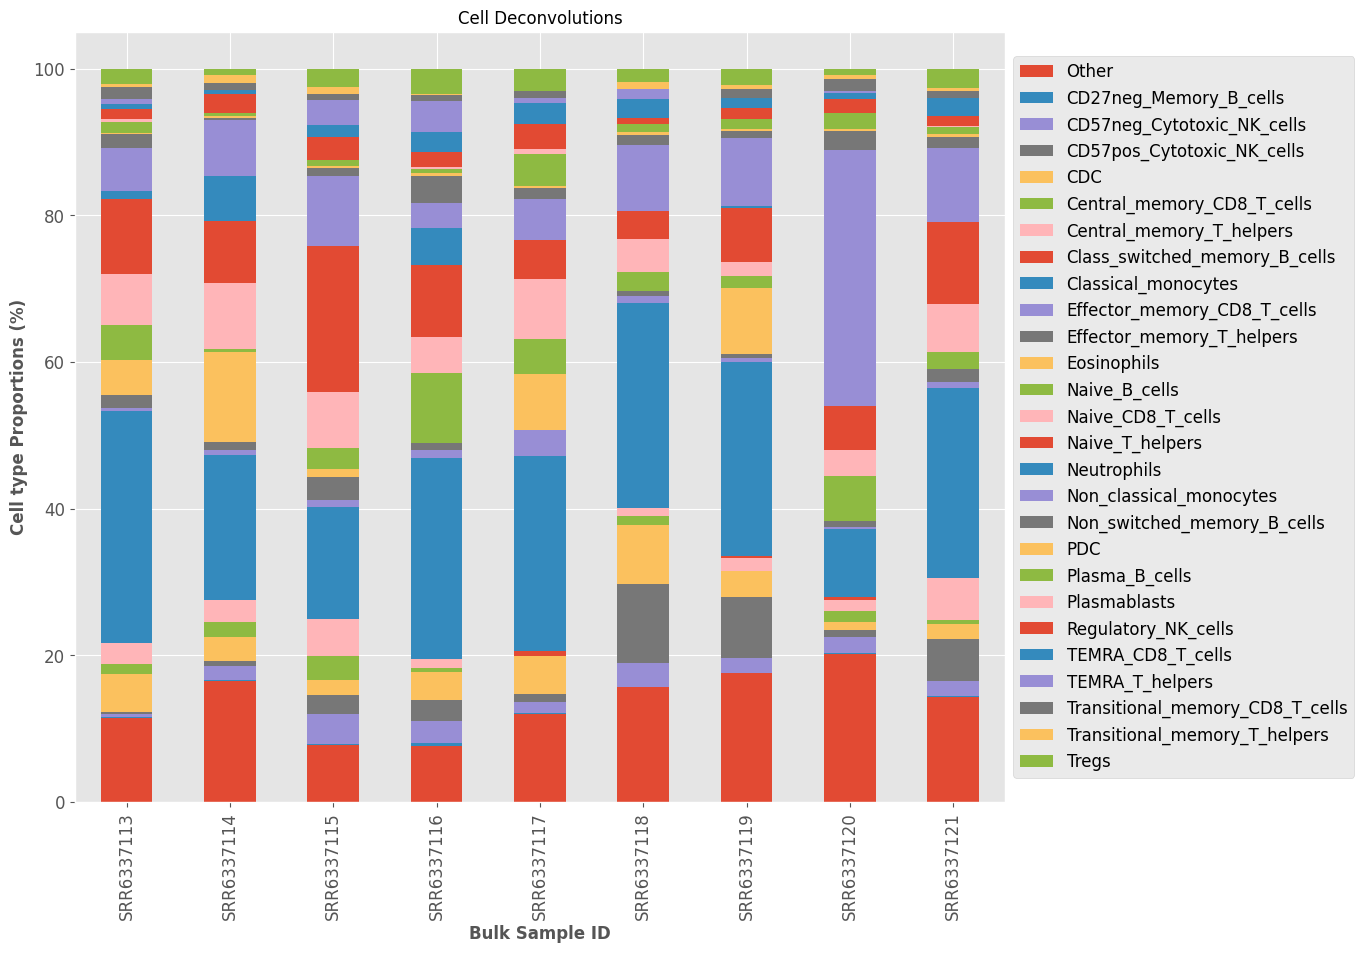

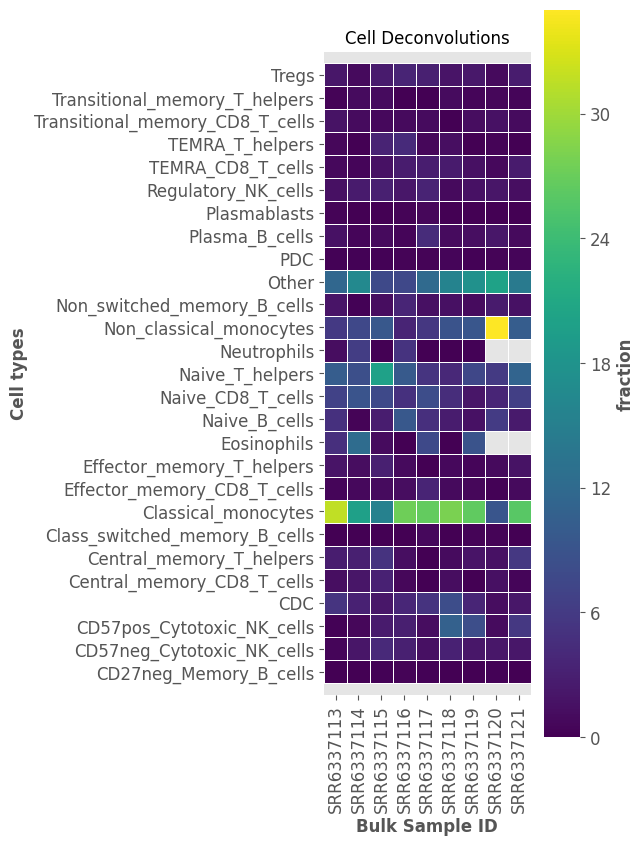

In [29]:
# cell proportion plots
plotter.stack_plot(k_preds_child.T)
plotter.heat_map(k_preds_child.T)

In [ ]:
# check for intersections
flatten(k_preds_100, cytof1)

array([[<AxesSubplot: title={'center': 'B_cells, corr = 0.89\np = 0.001'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.273\np = 0.477'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = 0.03\np = 0.94'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Lymphocytes, corr = 0.445\np = 0.23'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'Monocytes, corr = 0.452\np = 0.222'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'NK_cells, corr = 0.837\np = 0.005'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': '

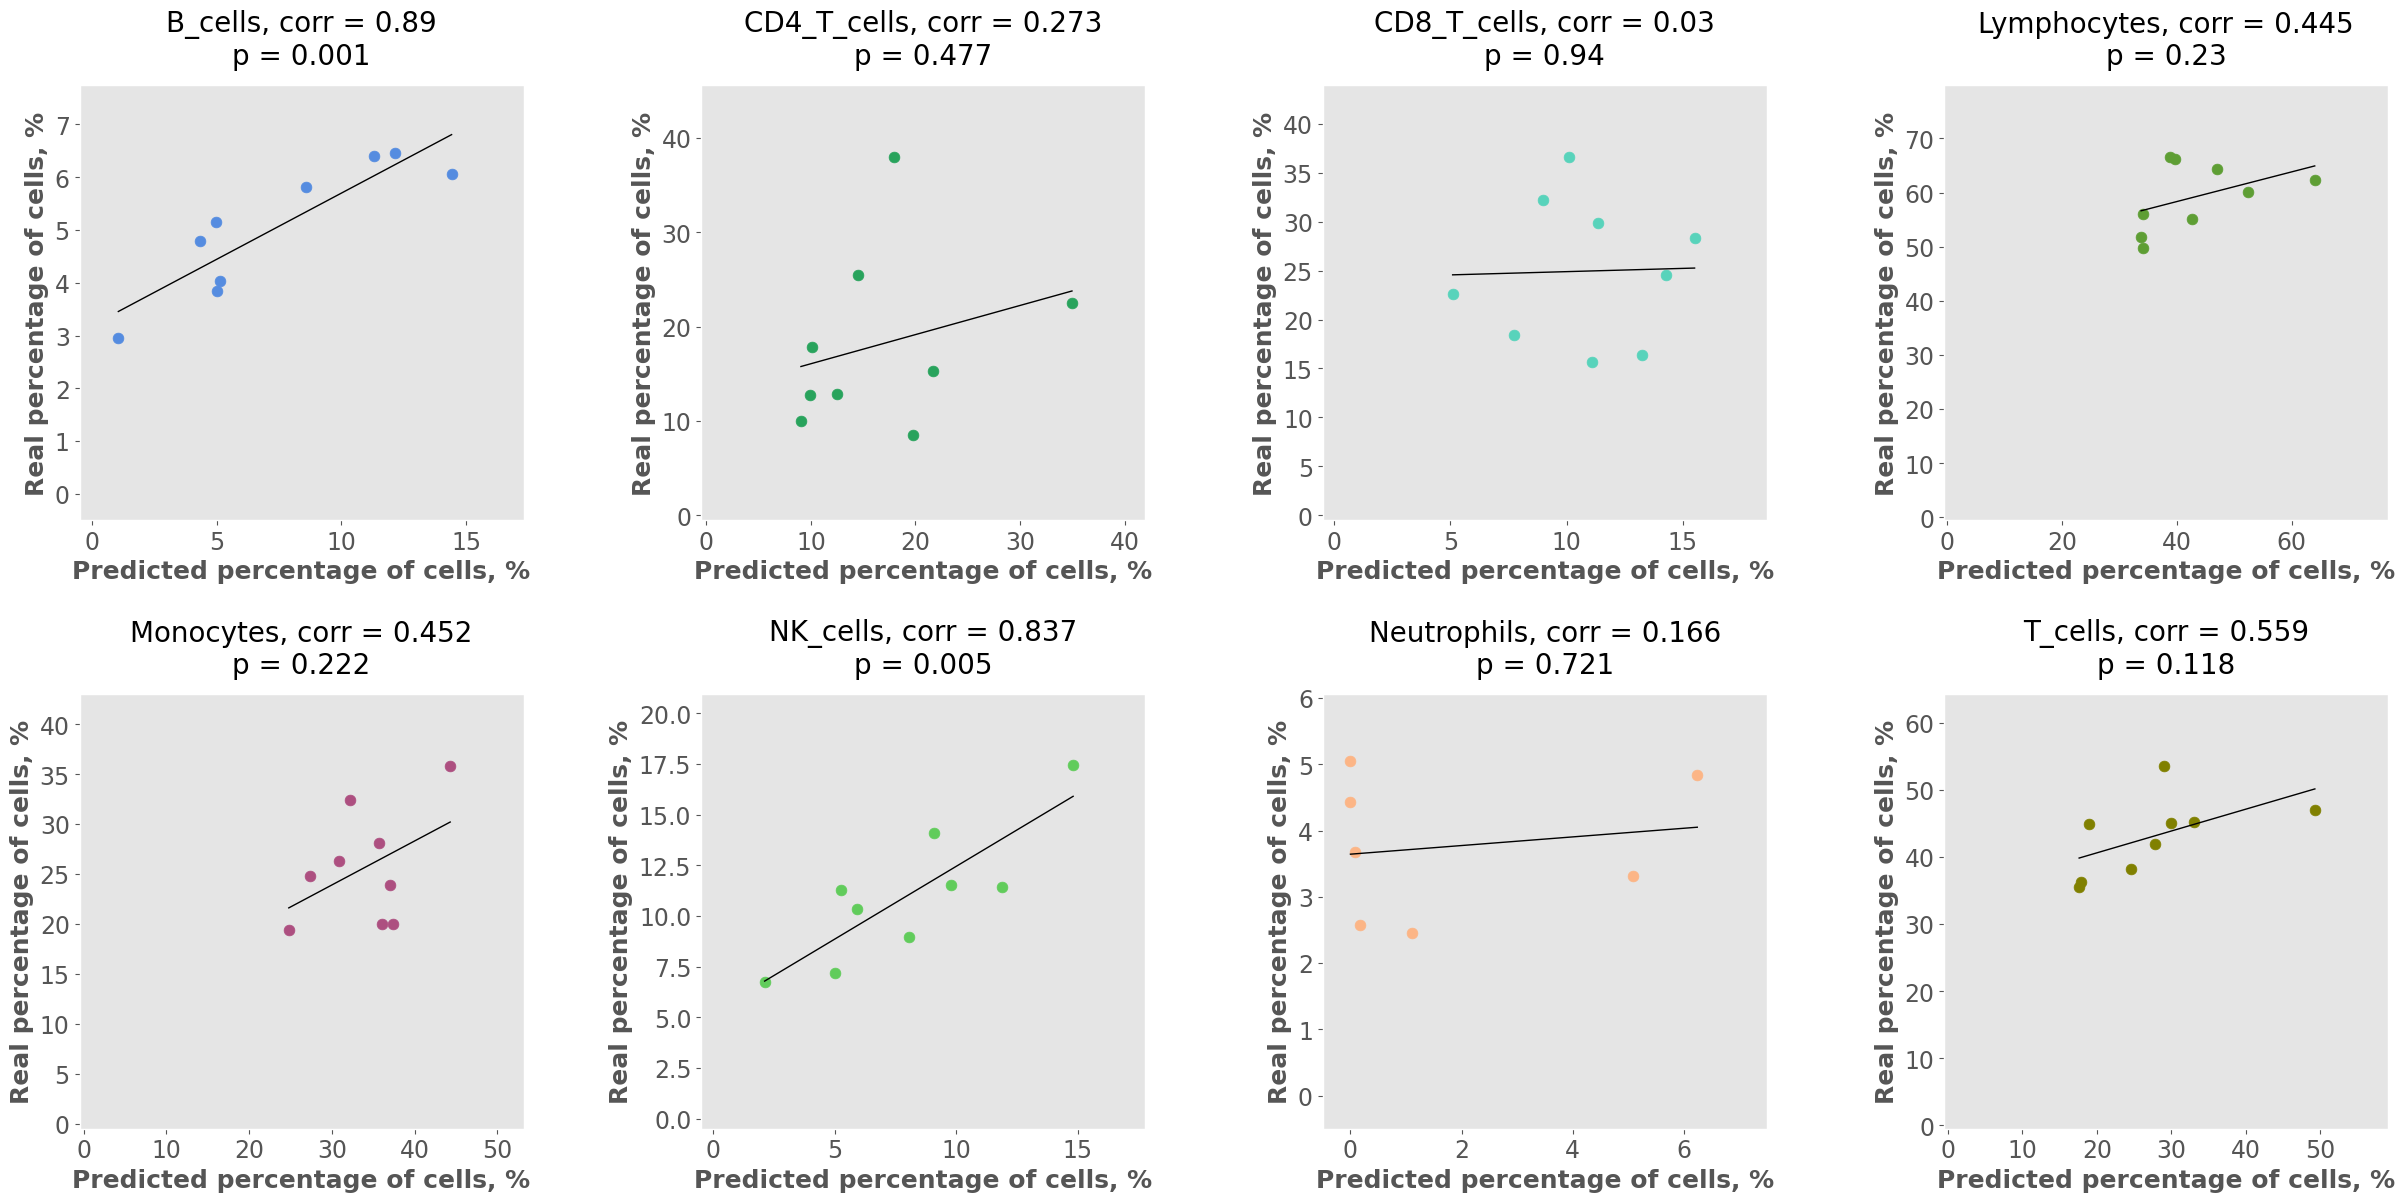

In [30]:
plotter.corr_plot(k_preds_100, cytof1, pallete=cells_p)

Statistical Tests
------------------------
RMSE: 11.392 
Pearson Correlation Coefficient: 0.839 
P value: 0.0 
R^2: 0.644


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

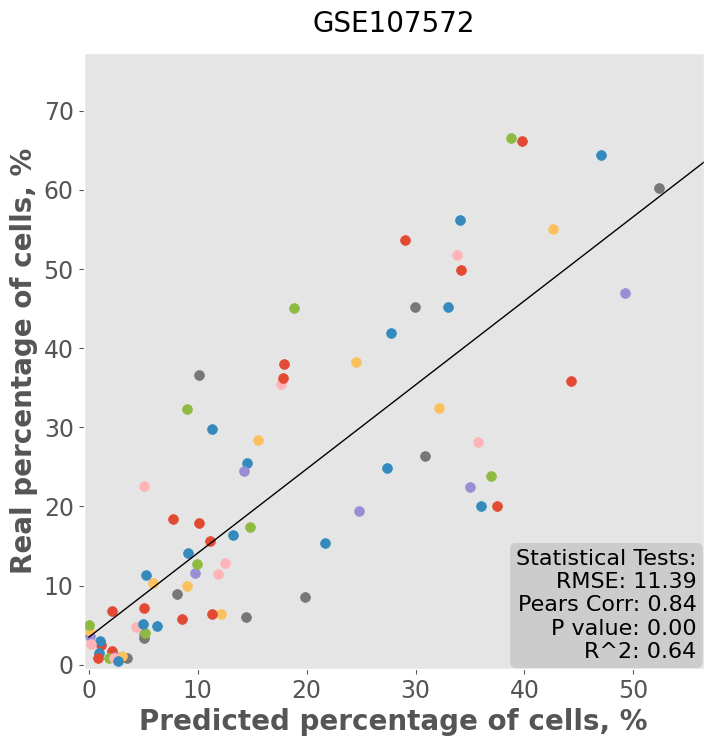

In [31]:
plotter.print_cell_whole(k_preds_100, cytof1, pallete = cells_p, title=title, stat=True)

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {2.38 +/- 3.343}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {-1.431 +/- 10.588}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-14.136 +/- 7.974}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of Lymphocytes: {-16.208 +/- 9.217}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of Monocytes: {8.3 +/- 6.072}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of NK_cells: {-3.021 +/- 2.127}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesS

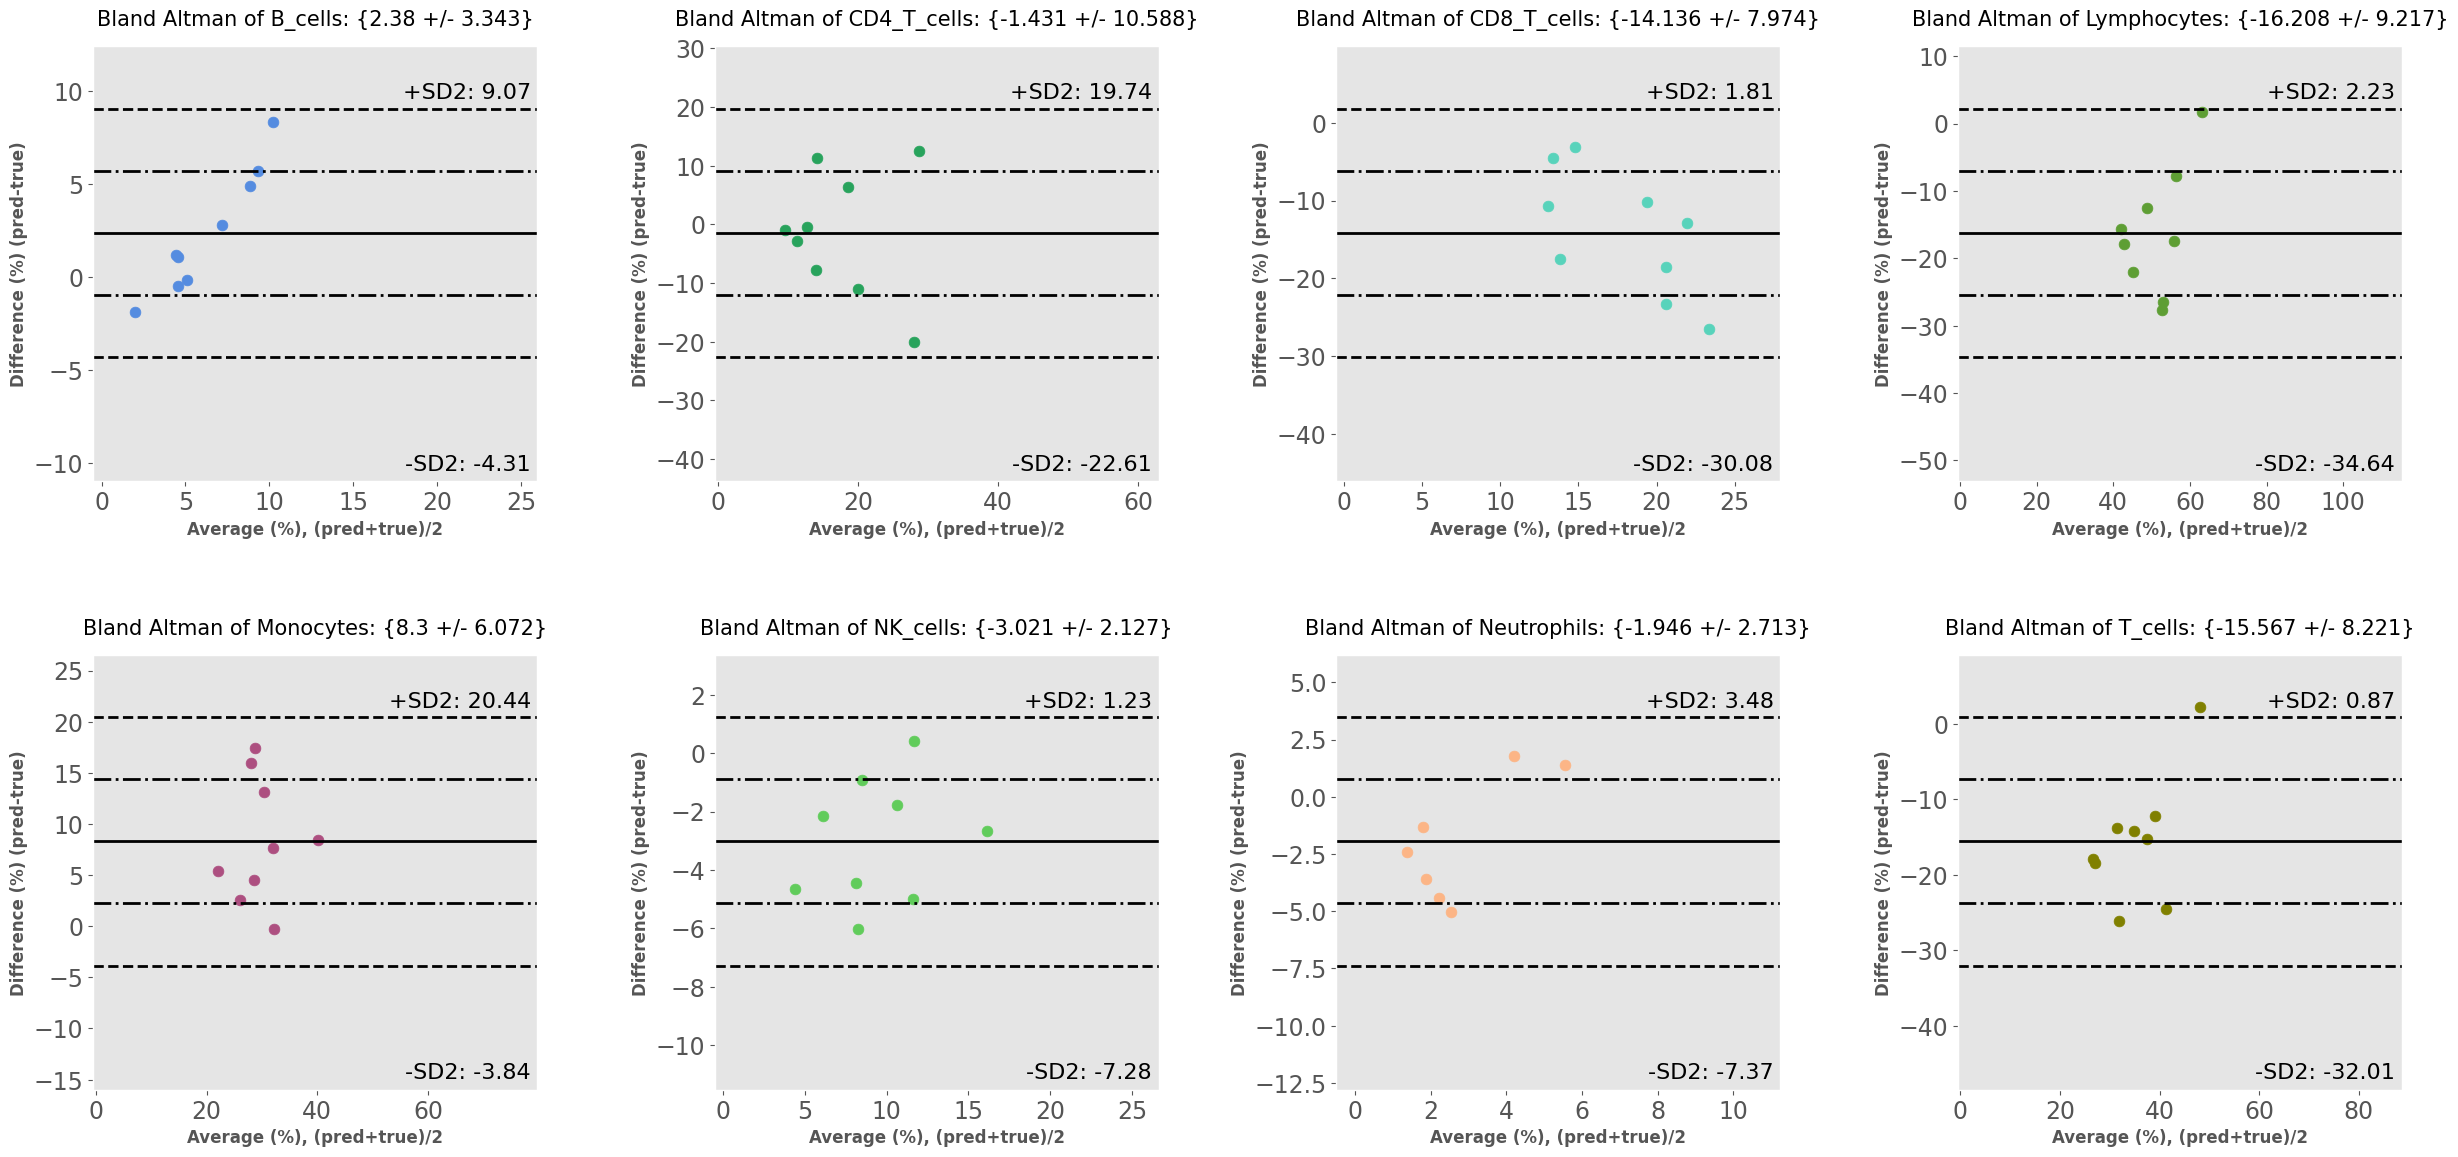

In [32]:
plotter.bland_altman(k_preds_100, cytof1, pallete = cells_p)

array([[<AxesSubplot: title={'center': 'Bland Altman of SRR6337113: {-6.768 +/- 14.342}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337114: {-6.103 +/- 8.167}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337115: {0.983 +/- 6.213}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337116: {-2.435 +/- 12.094}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of SRR6337117: {-4.609 +/- 7.029}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337118: {-8.057 +/- 14.242}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
       

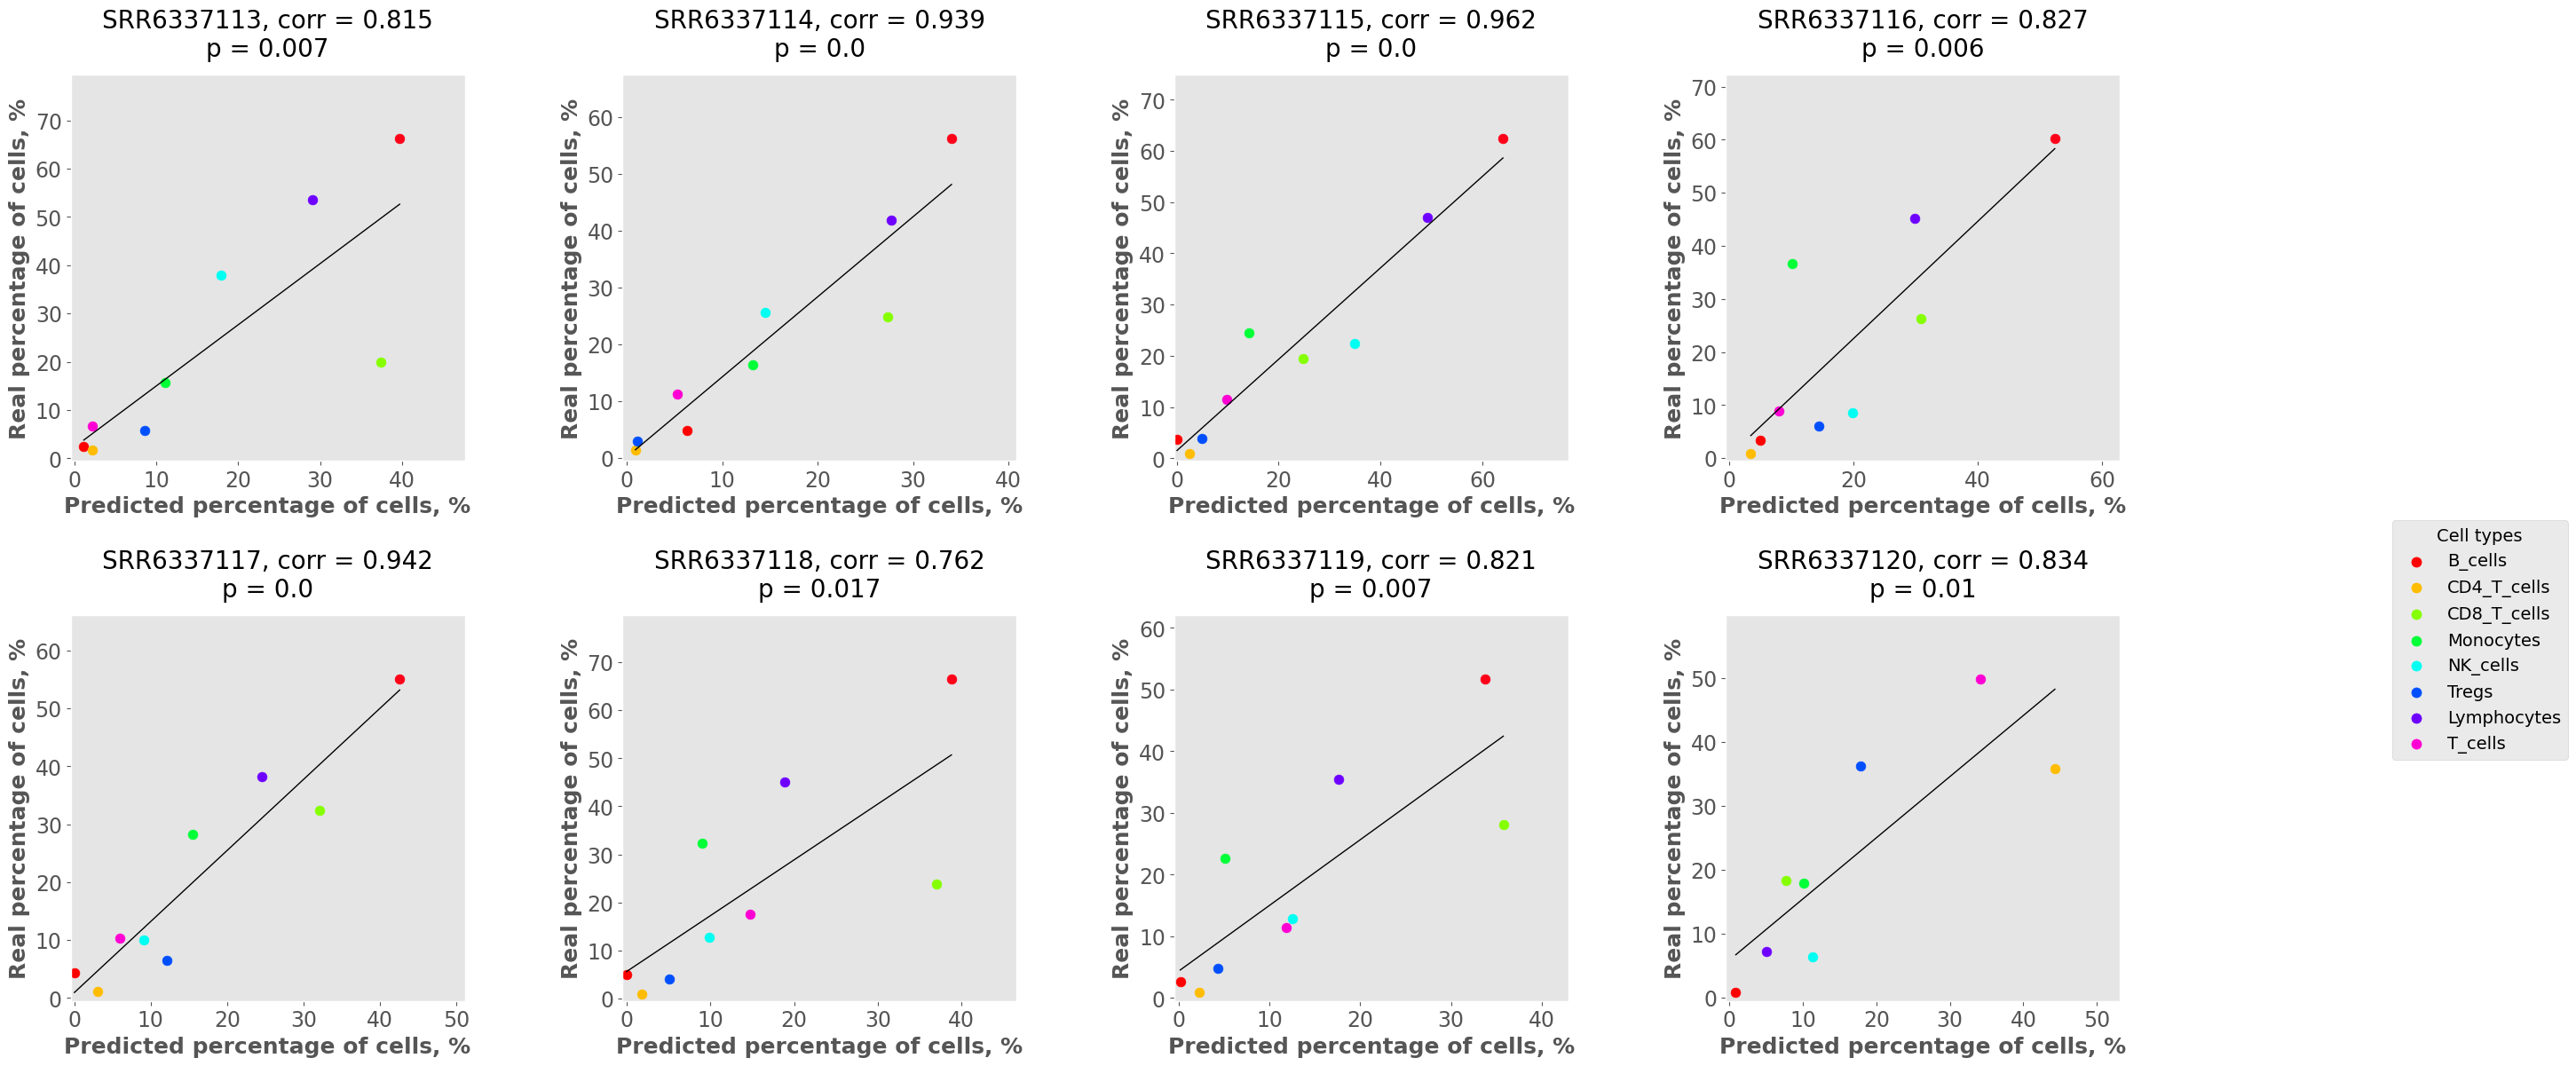

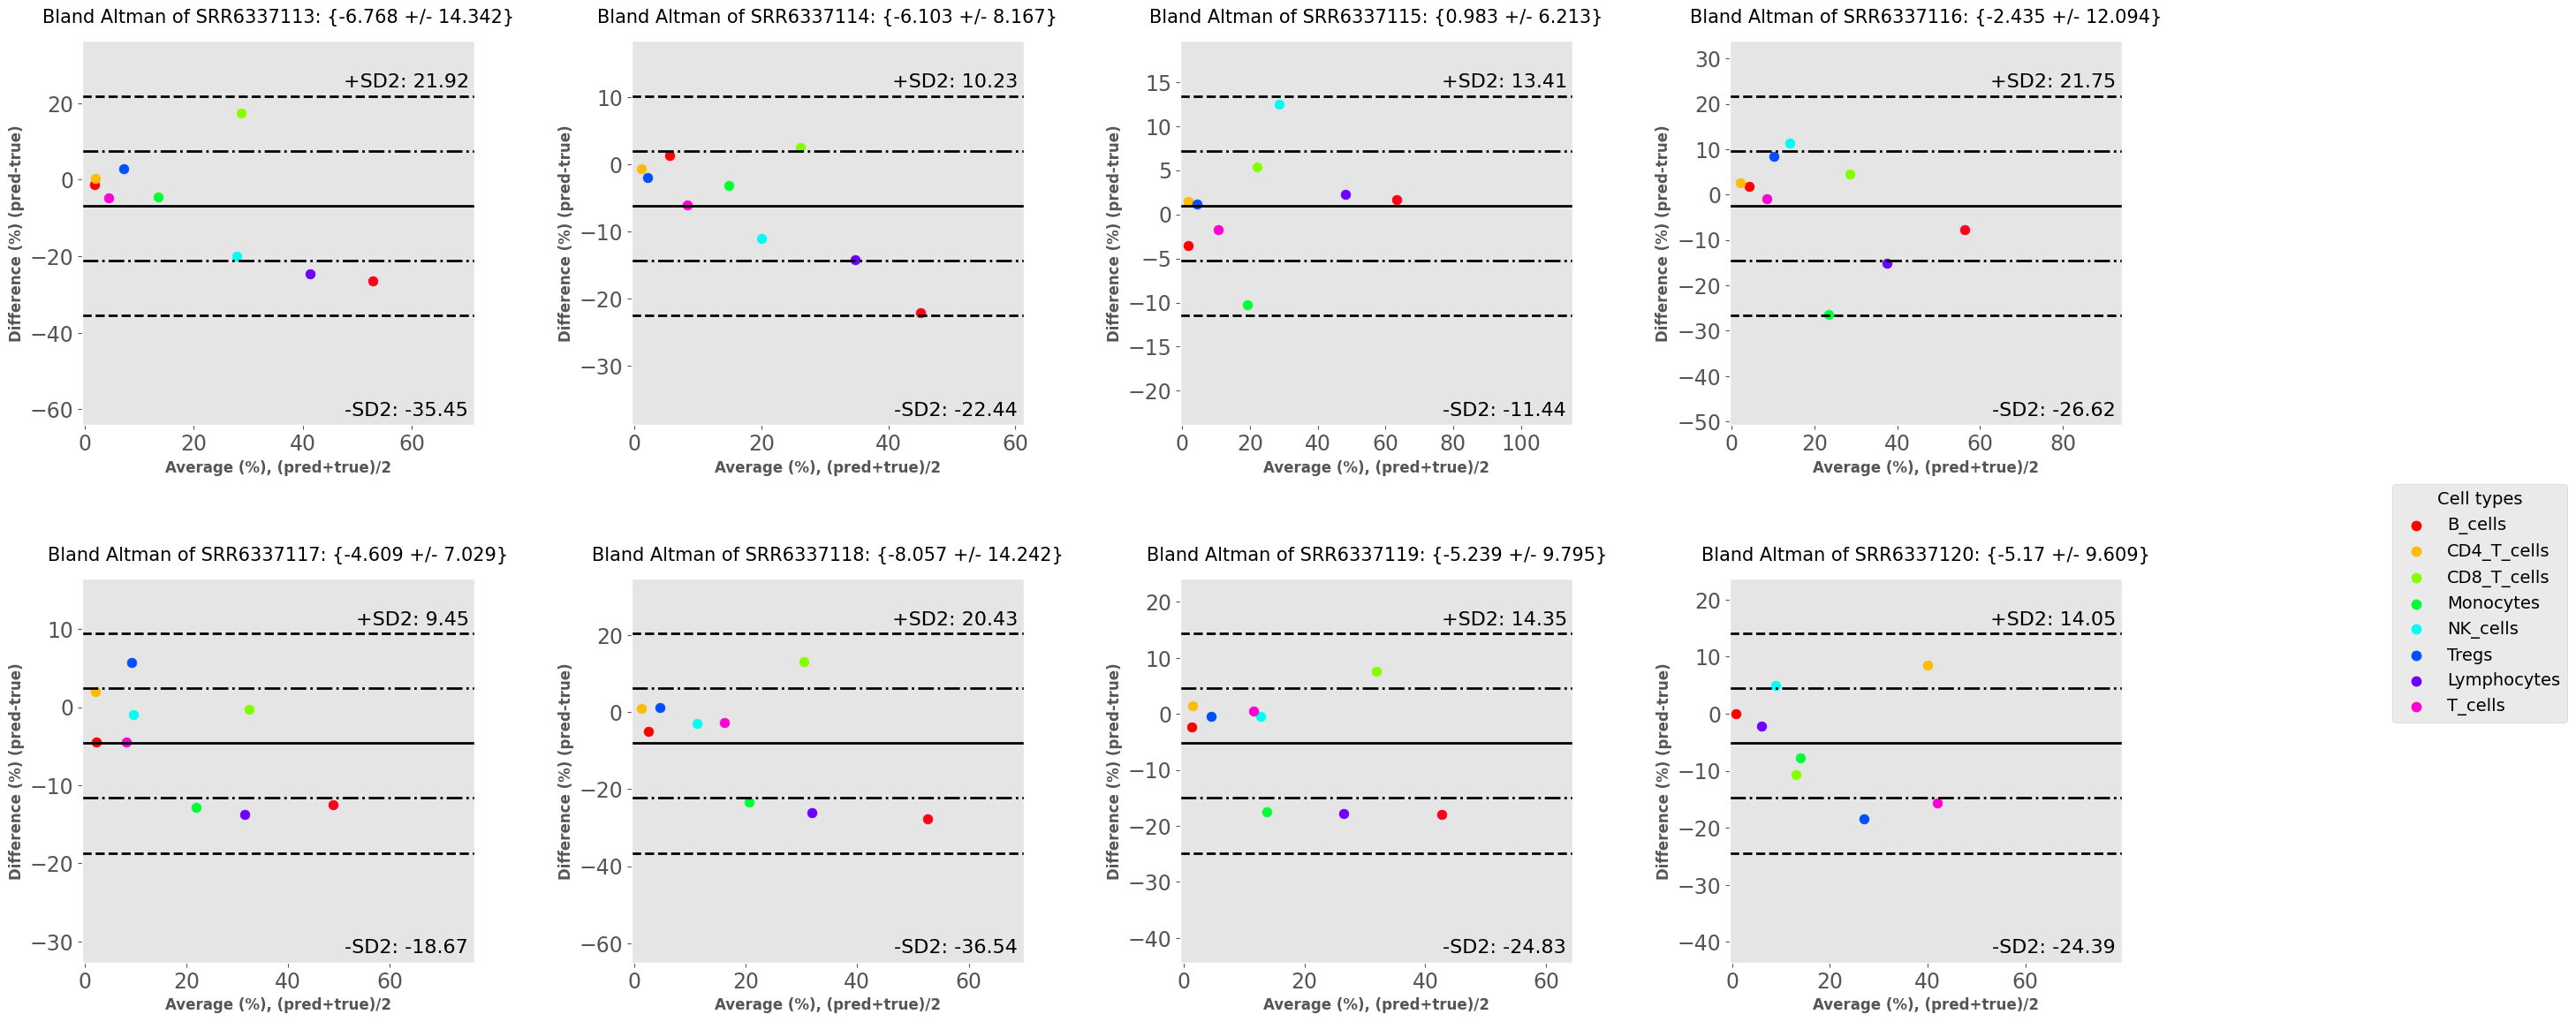

In [33]:
# get a color pallete for color samples
ind_names = k_preds_100.index.intersection(cytof1.index)
sample_color = plotter.get_cmap(len(ind_names))
plotter.plot_sample(k_preds_100, cytof1, pallete = sample_color)
plotter.bland_altman_v2(k_preds_100, cytof1, pallete = sample_color)

## GSE1479433 <a class="anchor" id="3_2"></a>

In [223]:
k_preds2 = model.predict(bulk2) 
k_preds2.loc['Lymphocytes'] = k_preds2.loc[['B_cells', 'T_cells', 'NK_cells']].sum()
k_preds2_100 = k_preds2 * 100

# drop parent nodes so we can plot child nodes stack plots
parent_nodes = ['Non_plasma_B_cells', 'Monocytes', 'Granulocytes', 'B_cells', 'T_cells', 'NK_cells', 'Myeloid_cells', 'Lymphoid_cells', 'Lymphocytes', 'CD8_T_cells', 'Cytotoxic_NK_cells', 'CD4_T_cells', 'Memory_T_helpers', 'Memory_CD8_T_cells']
k_preds2_child = k_preds2_100.drop(parent_nodes)

Expressions OK


In [ ]:
# cell proportion plots
plotter.stack_plot(k_preds2_child.T)
plotter.heat_map(k_preds2_child.T)

In [ ]:
# check for intersections
flatten(k_preds2_100, cytof2)

In [ ]:
plotter.corr_plot(k_preds2_100, cytof2, pallete=cells_p)

In [ ]:
plotter.print_cell_whole(k_preds2_100, cytof2, pallete = cells_p, title=title, stat=True)

In [ ]:
plotter.bland_altman(k_preds2_100, cytof2, pallete = cells_p)

In [ ]:
# get a color pallete for color samples
ind_names = k_preds2_100.index.intersection(cytof2.index)
sample_color = plotter.get_cmap(len(ind_names))
plotter.plot_sample(k_preds2_100, cytof2, pallete = sample_color, specific_col='F0598')
plotter.bland_altman_v2(k_preds2_100, cytof2, pallete = sample_color,specific_col='F0598')

#### SVR

In [36]:
signature = pd.read_csv('./cellanneal/example_data/sc_PBMC_gene_mean_signature.csv',index_col=0)
bulk2 = pd.read_csv('../data/GSE107572_expr.tsv.tar.gz',sep='\t',index_col=0)
bulk = pd.read_csv('../data/GSE1479433.tsv', sep='\t', index_col=0)

In [37]:
set1 = set(bulk.index)
set2 = set(bulk2.index)
set3 = set(signature.index)
intersection = (set1.intersection(set2)).intersection(set3)
inter = list(intersection)

In [38]:
signature = signature.filter(items=inter,axis=0)
bulk = bulk.filter(items=inter,axis=0)
bulk2 = bulk2.filter(items=inter,axis=0)

In [39]:
print(signature.shape, bulk.shape, bulk2.shape)

(12998, 18) (12998, 45) (12998, 9)


In [40]:
scaler = StandardScaler()
  
# transform data
train  = scaler.fit_transform(signature)
test_data = scaler.fit_transform(bulk2)
ind = bulk2.columns

## GSE107572 <a class="anchor" id="4_1"></a>

In [42]:
genes = bulk.index
ind = bulk2.columns
Nus=[0.25, 0.5, 0.75]

SVRcoef = np.zeros((signature.shape[1], bulk2.shape[1]))
Selcoef = np.zeros((bulk.shape[0], bulk2.shape[1]))

for i in tqdm(range(bulk2.shape[1])):
    sols = [NuSVR(kernel='linear', nu=nu).fit(train,test_data[:,i]) for nu in Nus]
    im_name = signature.columns
    RMSE = [mse(sol.predict(train), test_data[:,i]) for sol in sols]
    Selcoef[sols[np.argmin(RMSE)].support_, i] = 1
    SVRcoef[:,i] = np.maximum(sols[np.argmin(RMSE)].coef_,0)
    SVRcoef[:,i] = SVRcoef[:,i]/np.sum(SVRcoef[:,i])
svr_preds = pd.DataFrame(SVRcoef,index=im_name, columns=ind)
svr_preds = svr_preds.reindex(sorted(svr_preds.columns), axis=1)
svr_preds

100%|██████████| 9/9 [39:28<00:00, 263.12s/it]


,SRR6337113,SRR6337114,SRR6337115,SRR6337116,SRR6337117,SRR6337118,SRR6337119,SRR6337120,SRR6337121
CD4-naive,0.399826,0.441579,0.353230,0.302607,0.381199,0.383567,0.356523,0.367767,0.398517
CD14,0.182913,0.135236,0.165232,0.225079,0.194101,0.147068,0.176268,0.172425,0.142639
CD4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NK,0.000000,0.000000,0.011217,0.015759,0.000000,0.008228,0.014909,0.000000,0.003361
CD8,0.000000,0.000000,0.000000,0.004561,0.000000,0.000000,0.000000,0.000000,0.000000
CD16,0.000000,0.011068,0.029135,0.034969,0.004896,0.024246,0.029785,0.023335,0.036728
B-naive,0.000000,0.000000,0.011737,0.013079,0.000000,0.004047,0.002863,0.013635,0.015780
Treg,0.035601,0.029290,0.000000,0.000000,0.037626,0.011211,0.019076,0.044592,0.016229
gdT,0.132997,0.123888,0.174178,0.168760,0.124317,0.166424,0.157296,0.102756,0.170784
CD8-naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
svr_preds_100 = svr_preds * 100

In [44]:
svr_preds_copy = svr_preds_100.copy()
svr_preds_copy.loc['B_cells'] = svr_preds_copy.loc[['B', 'B-naive']].sum()
svr_preds_copy.loc['CD4_T_cells'] = svr_preds_copy.loc[['CD4', 'CD4-naive']].sum()
svr_preds_copy.loc['CD8_T_cells'] = svr_preds_copy.loc[['CD8']].sum()
svr_preds_copy.loc['NK_cells'] = svr_preds_copy.loc[['NK']].sum()
svr_preds_copy.loc['Tregs'] = svr_preds_copy.loc[['Treg']].sum()
svr_preds_copy.loc['T_cells'] = svr_preds_copy.loc[['CD8_T_cells', 'CD4_T_cells', 'Tregs', 'T_undef']].sum()
svr_preds_copy.loc['Lymphocytes'] = svr_preds_copy.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [45]:
svr_preds_copy

,SRR6337113,SRR6337114,SRR6337115,SRR6337116,SRR6337117,SRR6337118,SRR6337119,SRR6337120,SRR6337121
CD4-naive,39.982609,44.157903,35.323004,30.260694,38.119864,38.356704,35.652268,36.776715,39.851673
CD14,18.291275,13.523550,16.523151,22.507943,19.410102,14.706756,17.626796,17.242513,14.263899
CD4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NK,0.000000,0.000000,1.121668,1.575931,0.000000,0.822825,1.490900,0.000000,0.336123
CD8,0.000000,0.000000,0.000000,0.456075,0.000000,0.000000,0.000000,0.000000,0.000000
CD16,0.000000,1.106751,2.913491,3.496883,0.489563,2.424627,2.978509,2.333461,3.672767
B-naive,0.000000,0.000000,1.173731,1.307854,0.000000,0.404653,0.286258,1.363539,1.577973
Treg,3.560057,2.929000,0.000000,0.000000,3.762556,1.121080,1.907567,4.459222,1.622890
gdT,13.299675,12.388773,17.417818,16.876048,12.431685,16.642419,15.729586,10.275575,17.078372
CD8-naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
flatten(svr_preds_copy, cytof1)

Index(['B_cells', 'CD4_T_cells', 'CD8_T_cells', 'NK_cells', 'Tregs', 'T_cells',
       'Lymphocytes'],
      dtype='object')
Index(['SRR6337113', 'SRR6337114', 'SRR6337115', 'SRR6337116', 'SRR6337117',
       'SRR6337118', 'SRR6337119', 'SRR6337120', 'SRR6337121'],
      dtype='object')


array([[<AxesSubplot: title={'center': 'B_cells, corr = -0.101\np = 0.795'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.533\np = 0.14'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = 0.594\np = 0.092'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Lymphocytes, corr = -0.131\np = 0.738'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'NK_cells, corr = 0.245\np = 0.525'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'T_cells, corr = -0.041\np = 0.916'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center

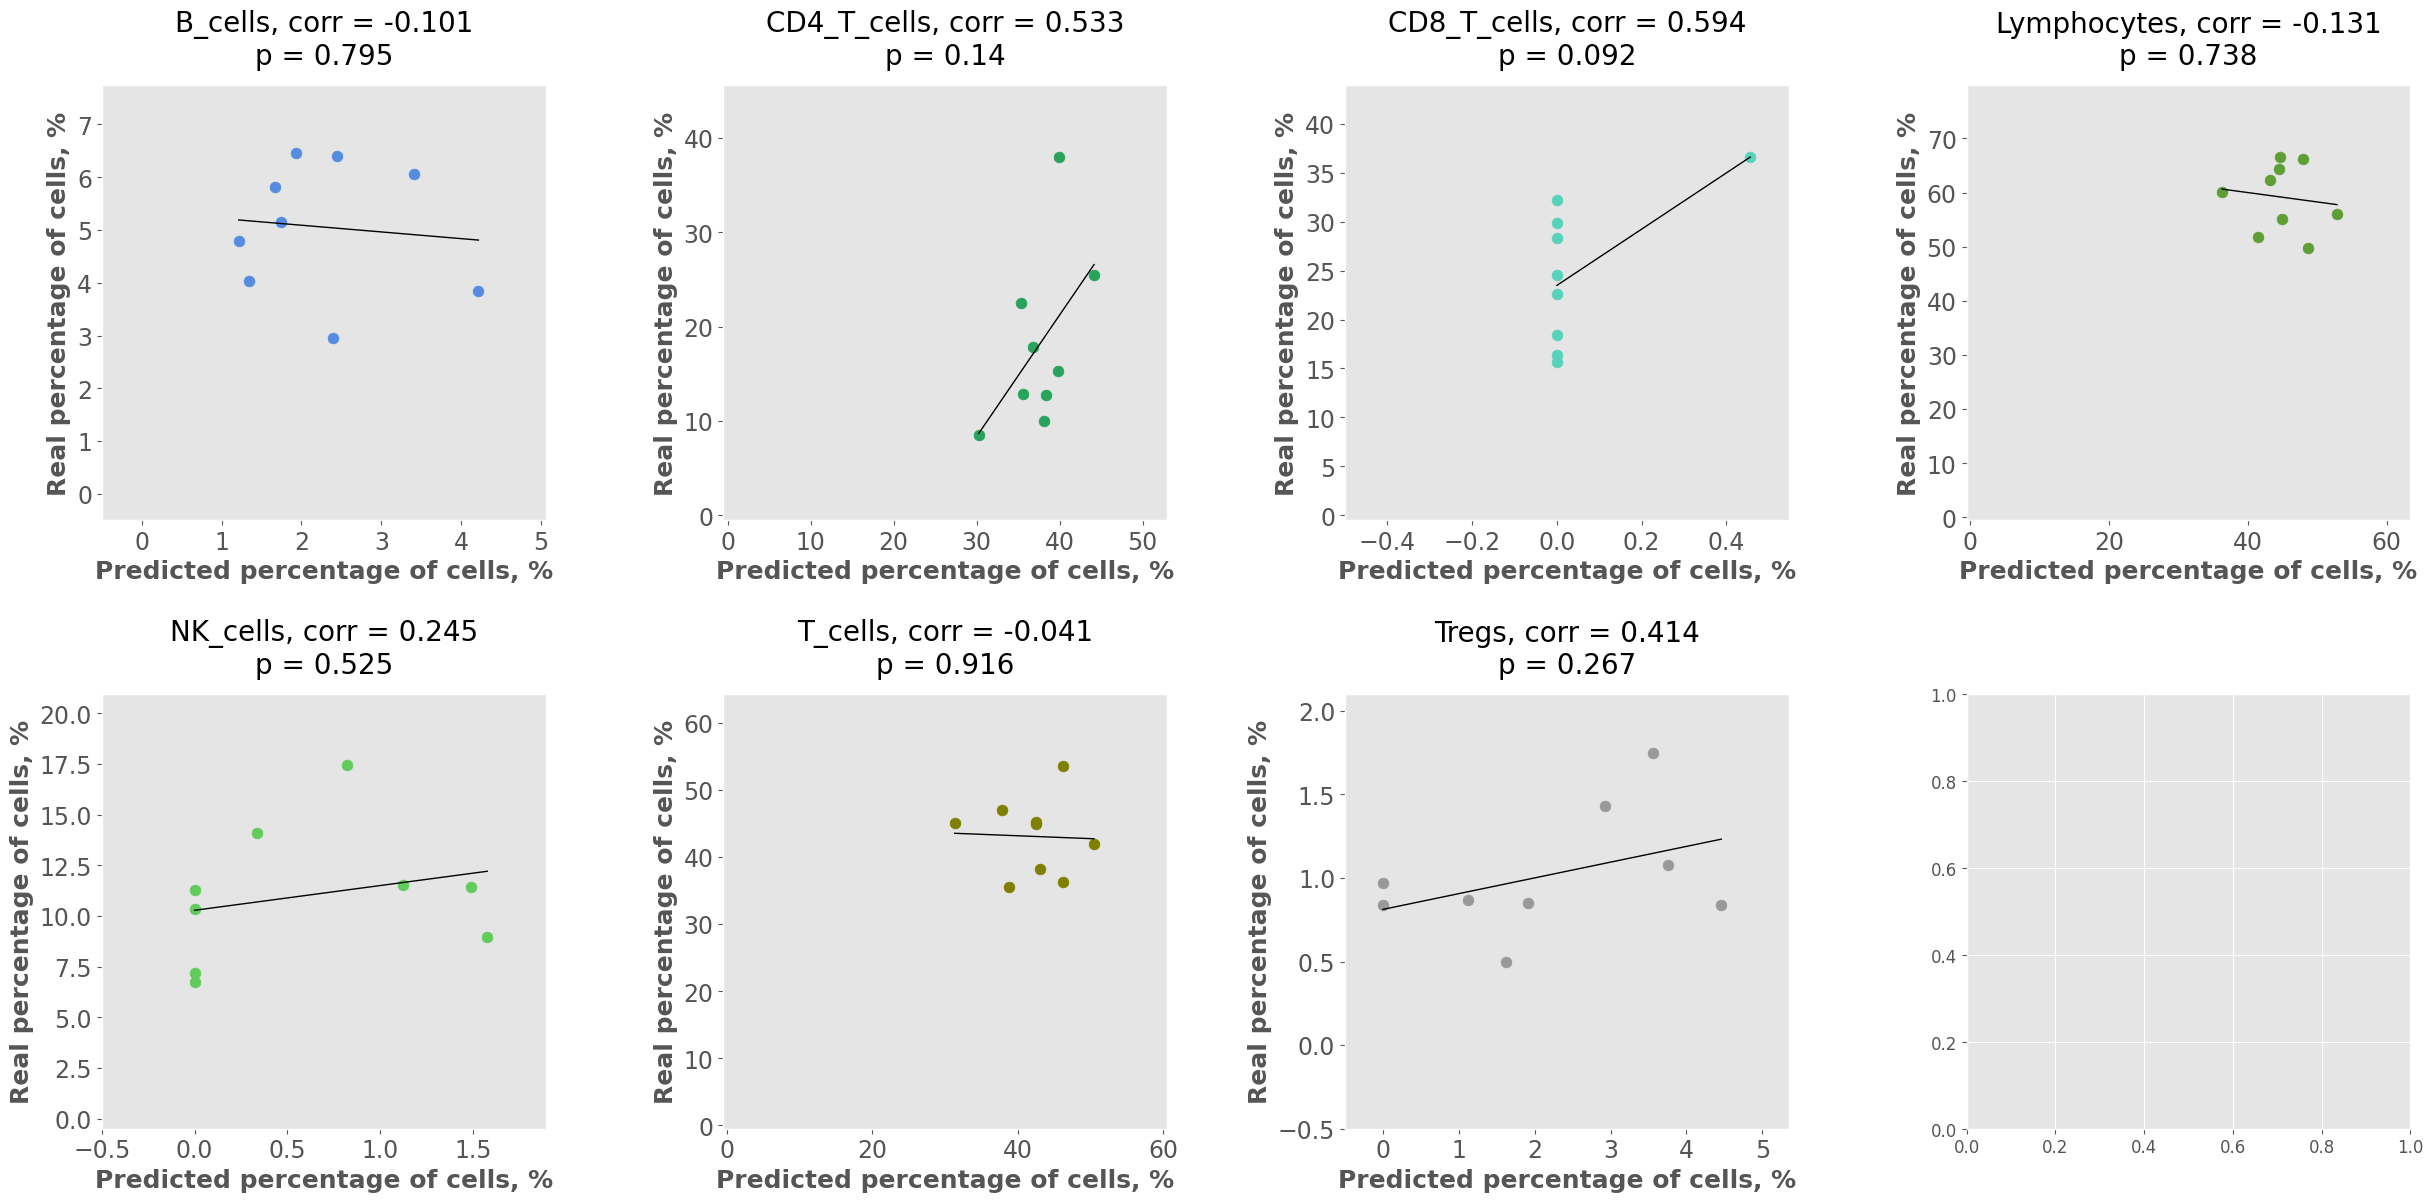

In [47]:
plotter.corr_plot(svr_preds_copy, cytof1, pallete=cells_p)

Statistical Tests
------------------------
RMSE: 14.916 
Pearson Correlation Coefficient: 0.756 
P value: 0.0 
R^2: 0.461


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

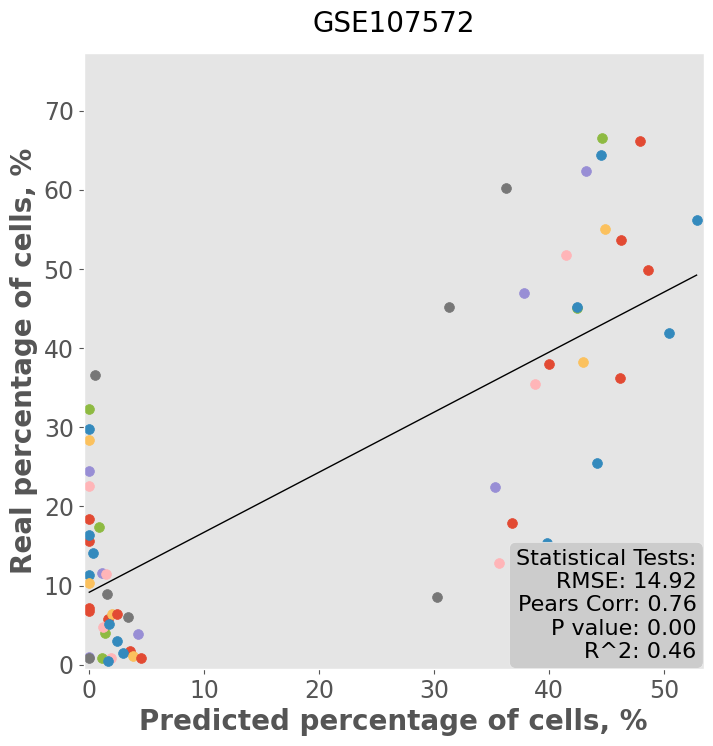

In [48]:
title = 'GSE107572'
plotter.print_cell_whole(svr_preds_copy, cytof1, pallete = cells_p, title=title, stat=True)

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {-2.791 +/- 1.664}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {19.469 +/- 7.937}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-24.904 +/- 7.275}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of Lymphocytes: {-14.225 +/- 8.259}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of NK_cells: {-10.411 +/- 3.239}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of T_cells: {-1.022 +/- 8.205}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <Ax

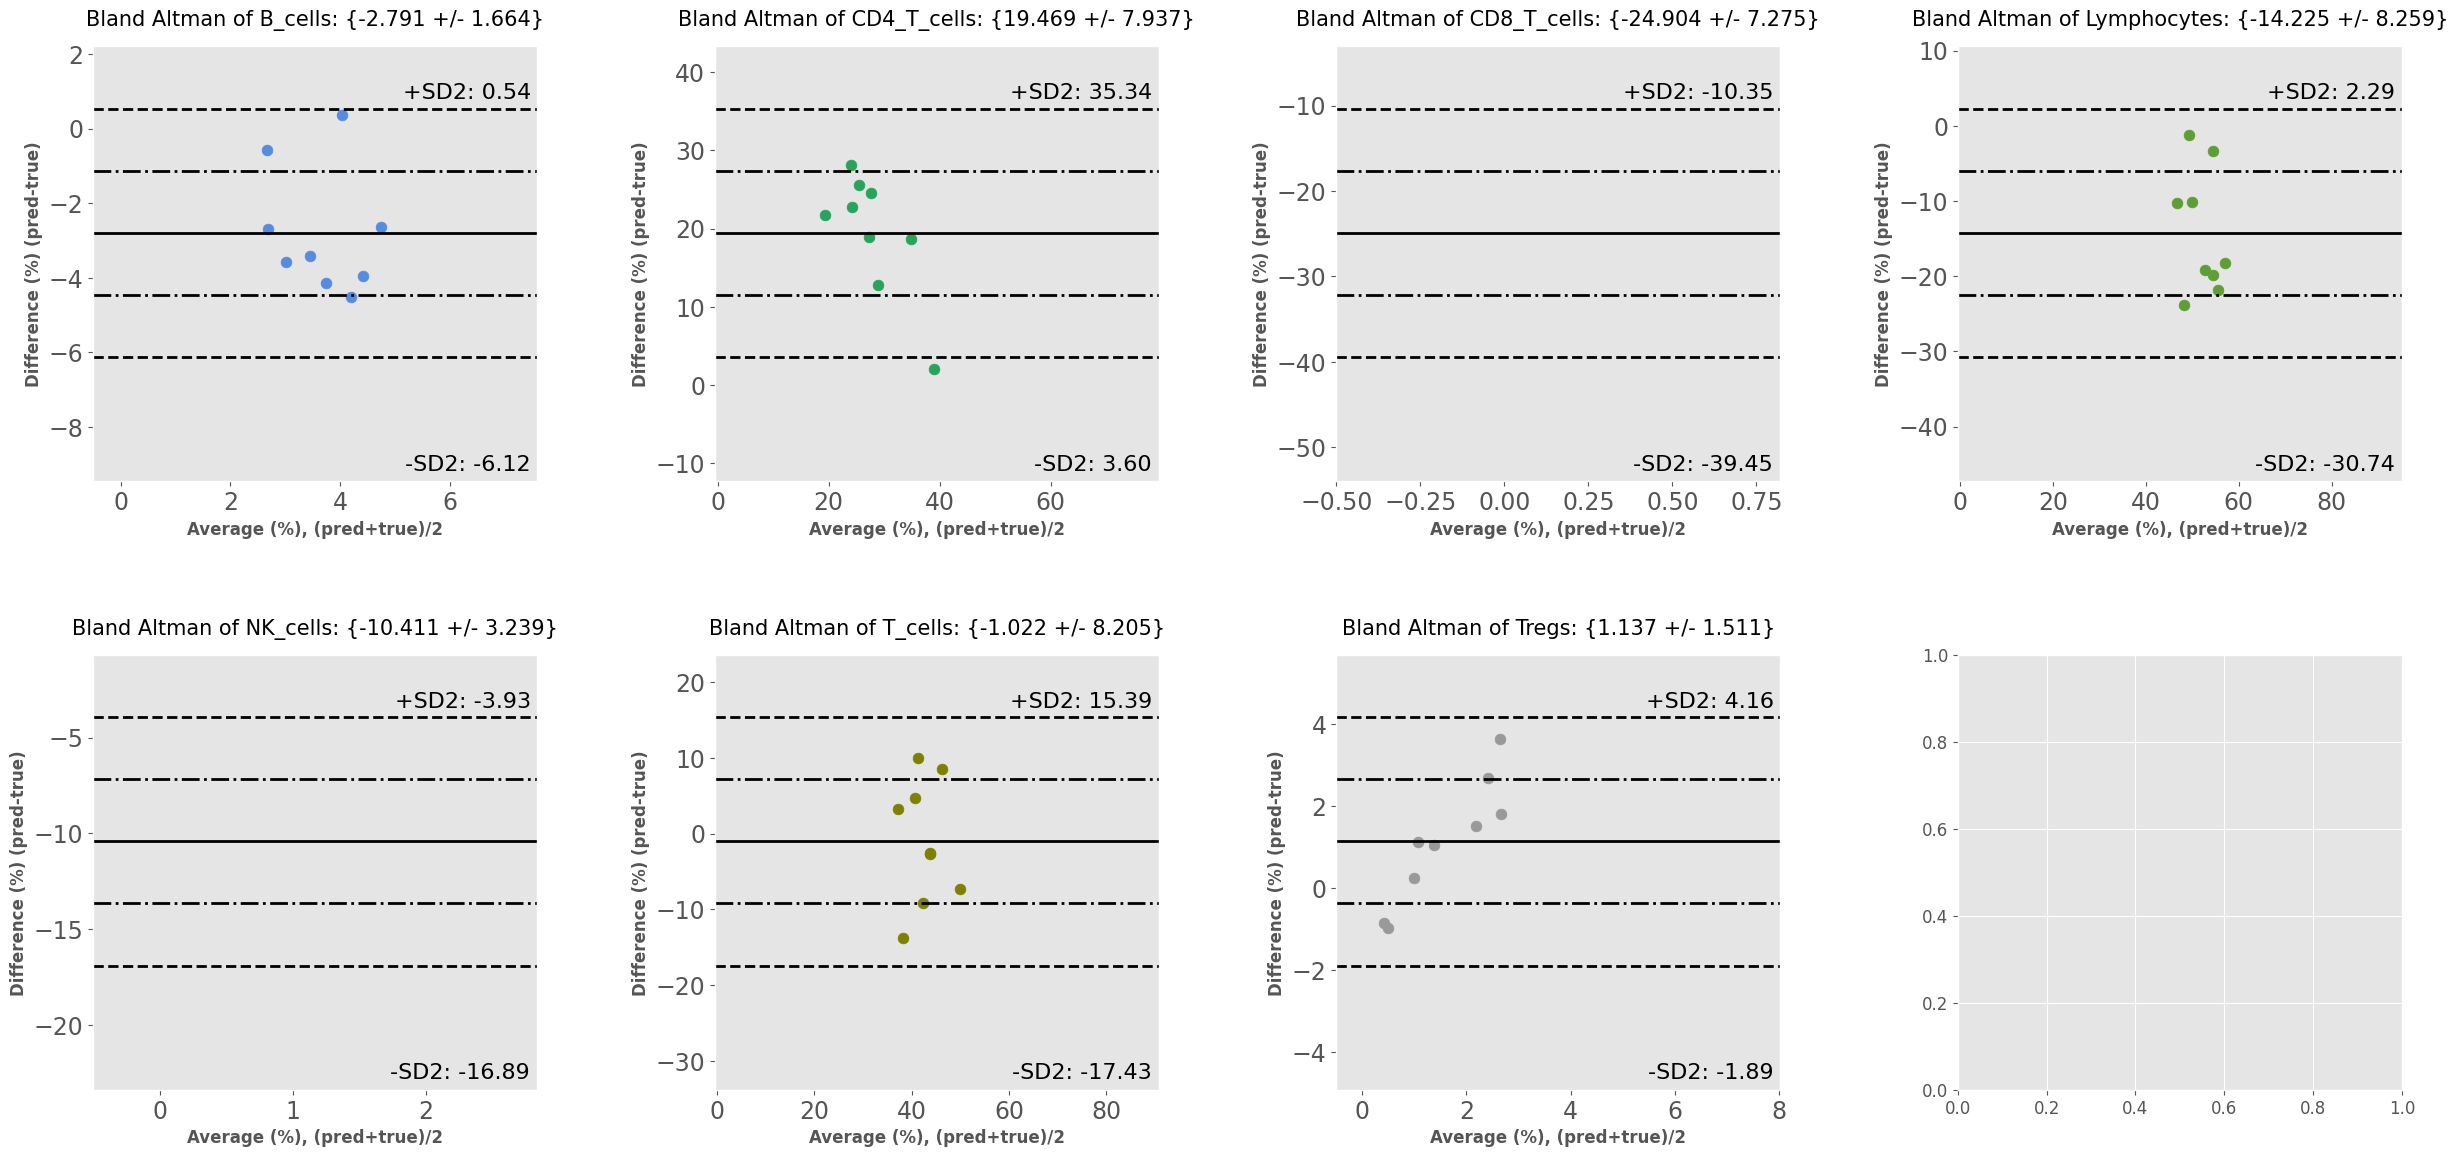

In [49]:
plotter.bland_altman(svr_preds_copy, cytof1, pallete = cells_p)

## GSE1479433 <a class="anchor" id="4_2"></a>

In [224]:
scaler = StandardScaler()
  
# transform data
train  = scaler.fit_transform(signature)
test_data = scaler.fit_transform(bulk)
ind = bulk.columns

In [225]:
genes = bulk.index
ind = bulk2.columns
Nus=[0.5]

SVRcoef = np.zeros((signature.shape[1], bulk2.shape[1]))
Selcoef = np.zeros((bulk.shape[0], bulk2.shape[1]))

for i in tqdm(range(bulk2.shape[1])):
    sols = [NuSVR(kernel='linear', nu=nu).fit(train,test_data[:,i]) for nu in Nus]
    im_name = signature.columns
    RMSE = [mse(sol.predict(train), test_data[:,i]) for sol in sols]
    Selcoef[sols[np.argmin(RMSE)].support_, i] = 1
    SVRcoef[:,i] = np.maximum(sols[np.argmin(RMSE)].coef_,0)
    SVRcoef[:,i] = SVRcoef[:,i]/np.sum(SVRcoef[:,i])
svr_preds_2 = pd.DataFrame(SVRcoef,index=im_name, columns=ind)
svr_preds_2 = svr_preds.reindex(sorted(svr_preds.columns), axis=1)
svr_preds_2

100%|██████████| 45/45 [1:01:08<00:00, 81.52s/it] 


,SRR6337113,SRR6337114,SRR6337115,SRR6337116,SRR6337117,SRR6337118,SRR6337119,SRR6337120,SRR6337121
CD4-naive,0.399826,0.441579,0.353230,0.302607,0.381199,0.383567,0.356523,0.367767,0.398517
CD14,0.182913,0.135236,0.165232,0.225079,0.194101,0.147068,0.176268,0.172425,0.142639
CD4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NK,0.000000,0.000000,0.011217,0.015759,0.000000,0.008228,0.014909,0.000000,0.003361
CD8,0.000000,0.000000,0.000000,0.004561,0.000000,0.000000,0.000000,0.000000,0.000000
CD16,0.000000,0.011068,0.029135,0.034969,0.004896,0.024246,0.029785,0.023335,0.036728
B-naive,0.000000,0.000000,0.011737,0.013079,0.000000,0.004047,0.002863,0.013635,0.015780
Treg,0.035601,0.029290,0.000000,0.000000,0.037626,0.011211,0.019076,0.044592,0.016229
gdT,0.132997,0.123888,0.174178,0.168760,0.124317,0.166424,0.157296,0.102756,0.170784
CD8-naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [226]:
svr_preds2_100 = svr_preds_2 * 100
svr_preds_copy2 = svr_preds2_100.copy()
svr_preds_copy2.loc['B_cells'] = svr_preds_copy2.loc[['B', 'B-naive']].sum()
svr_preds_copy2.loc['CD4_T_cells'] = svr_preds_copy2.loc[['CD4', 'CD4-naive']].sum()
svr_preds_copy2.loc['CD8_T_cells'] = svr_preds_copy2.loc[['CD8']].sum()
svr_preds_copy2.loc['NK_cells'] = svr_preds_copy2.loc[['NK']].sum()
svr_preds_copy2.loc['Tregs'] = svr_preds_copy2.loc[['Treg']].sum()
svr_preds_copy2.loc['T_cells'] = svr_preds_copy2.loc[['CD8_T_cells', 'CD4_T_cells', 'Tregs', 'T_undef']].sum()
svr_preds_copy2.loc['Lymphocytes'] = svr_preds_copy2.loc[['B_cells', 'T_cells', 'NK_cells']].sum()


# Methods to score which method performed the best

#### TODO
- Takes the difference, of true and predicted between cell types. The most with the lowest difference wins
- Make benchmarking plot that takes in a list of dataframes as input, takes the RMSE & Pearson between every sample and forms a plot where each datapoint is the RMSE and corrlation.

In [235]:
def benchmark_rmse(df_list, cytof, name_list):

    df_final = pd.DataFrame()
    length = 999
    for i, df in enumerate(df_list):
        ind_names = df.dropna().index.intersection(cytof.dropna().index)
        col_names = df.dropna().columns.intersection(cytof.dropna().columns)
        predicted_values = df.loc[ind_names, col_names]
        true_values = cytof.loc[ind_names, col_names]
        predicted_values = predicted_values.T
        true_values = true_values.T
        cells = true_values.columns
        stat = statsTest()

        temp2 = predicted_values.shape[1]
        if temp2 < length:
            length = temp2

        rmse_list = []
        for x, cell in enumerate(cells):
            val = stat.rmse(predicted_values[cell], true_values[cell])
            rmse_list.append(val)
        rmse_list = rmse_list[0:length]
        df_final[name_list[i]] = rmse_list
        if i == 0:
            index_name = predicted_values.columns
            df_final.index = index_name
    
    sns.lineplot(data=df_final)
    sns.scatterplot(data=df_final, legend=False)
    plt.xlabel("Cell Types")
    plt.ylabel("RMSE")
    plt.title("RMSE across different Methods at Cell type level")
            

def benchmark_correlation(df_list, cytof, name_list):
    df_final = pd.DataFrame()
    length = 999
    for i, df in enumerate(df_list):
        ind_names = df.index.intersection(cytof.index)
        col_names = df.columns.intersection(cytof.columns)
        predicted_values = df.loc[ind_names, col_names]
        true_values = cytof.loc[ind_names, col_names].astype(float)
        predicted_values = predicted_values.T
        true_values = true_values.T
        cells = true_values.columns
        stat = statsTest()

        temp2 = predicted_values.shape[1]
        if temp2 < length:
            length = temp2

        r_list = []
        for cell in cells:
            val = stat.correlation(predicted_values[cell], true_values[cell])
            r_list.append(val)
        r_list = r_list[0:length]
        df_final[name_list[i]] = r_list
        if i == 0:
            index_name = predicted_values.columns
            df_final.index = index_name
    
    display(df_final)
    
    #sns.lineplot(data=df_final)
    # sns.scatterplot(data=df_final, x='ind', y='cellanneal', legend=False)
    # sns.scatterplot(data=df_final, x='ind', y='Kassandra', legend=False)
    # sns.scatterplot(data=df_final, x='ind', y='SVR', legend=False)
    sns.lineplot(data=df_final)
    # sns.lineplot(data=df_final['cellanneal'])
    # sns.lineplot(data=df_final['Kassandra'], style='-')
    # sns.lineplot(data=df_final['SVR'], style= '.')
    #plt.ylim([-1, 1])
    plt.xlabel("Cell Types")
    plt.ylabel("Pearson Correlation (r)")
    plt.title("Pearson Correlation across different Methods at Cell type level")

def correlation_matrix(predicted, true):
    ind_names = predicted.index.intersection(true.index)
    col_names = predicted.columns.intersection(true.columns)
    predicted_values = predicted.loc[ind_names, col_names]
    true_values = true.loc[ind_names, col_names]
    true_values = true_values.add_suffix('_x')
    result = predicted_values.corrwith(true_values, axis = 0)
    display(result)

    

In [85]:
df_list = [ca_preds_copy, k_preds_100, svr_preds_copy]

In [127]:
names = ['cellanneal', 'Kassandra', 'SVR']

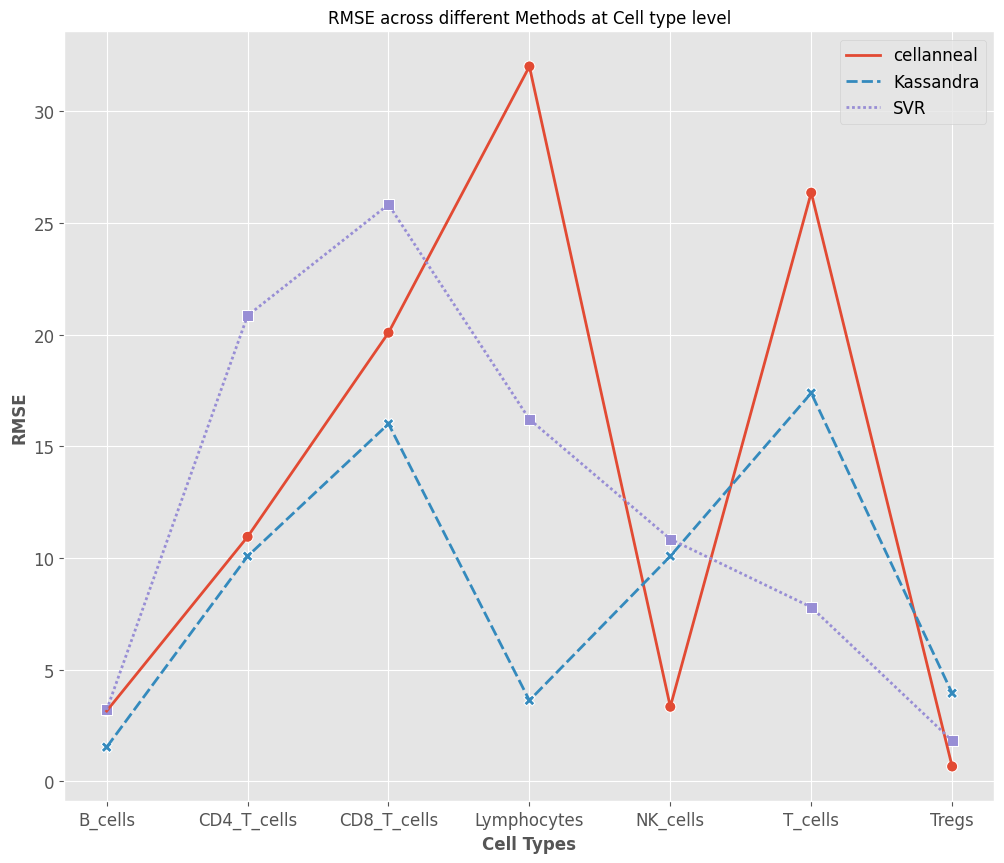

In [169]:
benchmark_rmse(df_list, cytof1, names)

,cellanneal,Kassandra,SVR
B_cells,0.428,-0.274,-0.101
CD4_T_cells,0.722,0.452,0.533
CD8_T_cells,0.746,0.03,0.594
NK_cells,0.894,0.273,0.245
Tregs,0.29,0.89,0.414
T_cells,0.595,0.559,-0.041
Lymphocytes,0.588,0.837,-0.131


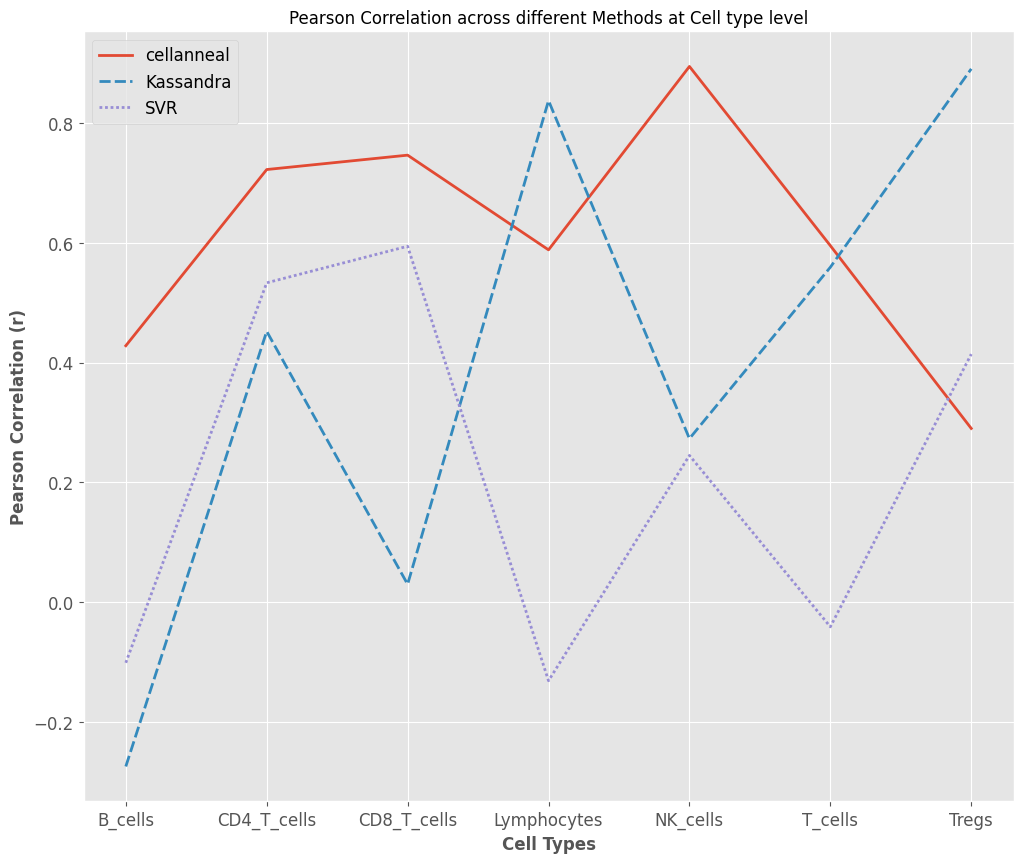

In [217]:
benchmark_correlation(df_list, cytof1, names)

In [242]:
df_list2 = [ca_preds_copy2, k_preds2_100, svr_preds_copy2]

In [243]:
cytof2 = cytof2.fillna(0)

In [ ]:
def method_selection(df_list, true, method_names):
    '''
    Calculates method selection based on multiple statistical tests: RMSE, R^2, Pearson Correlation

    Parameters:
        df_list: a list of predicted dataframes to compare one another to
        true: flow cytometry data that will allow us to benchmark

    Results:
        Prints out best methods
    '''